# 3. Análise de centralidade e comunidades no grafo bipartido de autoria

Neste notebook, vamos executar uma série de operações para consolidar um grafo de análise das relações de autoria. Vamos também atribuir uma nota a cada proposição, baseada no seu desempenho no processo legislativo, que será usada para informar essa análise.



## 3.1. Preparação


### 3.1.1. Imports

In [738]:
import itertools
import json
import os

from pathlib import Path
from collections import defaultdict
# import duckdb
import numpy as np
import pandas as pd
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from tramita.gold import (
    Event,
    add_column_from_graph,
    build_graph,
    merge_nodes,
    prune_graph,
)

from dotenv import load_dotenv

load_dotenv()
pd.set_option('display.max_rows', 20)

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "gold" / "outputs"
OUT_DIR.mkdir(exist_ok=True)
ACCESS_DIR = PROJECT_DIR / "gold" / "accessory_data"
ACCESS_DIR.mkdir(exist_ok=True)

NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

# with duckdb.connect(DB_PATH, read_only=True) as con:

COLLAB_NODES_CSV = OUT_DIR / "nodes_collab.csv"
COLLAB_EDGES_CSV = OUT_DIR / "edges_collab.csv"

MAIN_G_BTWN_JSON = ACCESS_DIR / "main_g_btwn.json"
MAIN_G_BTWN_FRAC_JSON = ACCESS_DIR / "main_g_btwn_frac.json"

### 3.1.2. Carga dos dados

In [739]:
event_df = pd.read_pickle(ACCESS_DIR / "full_event_df.pkl")
edges_df = pd.read_csv(EDGES_PATH_CSV)
nodes_df = pd.read_csv(NODES_PATH_CSV)

## 3.2. Qualificação de vértices de proposições de acordo com seu desempenho legislativo




Vamos rever as informações que temos a nosso dispor:

In [740]:
event_df.value_counts(['event', 'casa']).unstack()

casa,camara,senado
event,,
Event.APRESENTADO,28958.0,2789.0
Event.RECEBIDO_COMISSAO,31097.0,2313.0
Event.DESIGNADO_RELATOR_COMISSAO,16615.0,1335.0
Event.RETIRADO_PAUTA_COMISSAO,3904.0,165.0
Event.RETIRADO_PAUTA_PLENARIO,NaN,192.0
Event.APROVADA_URGENCIA,1425.0,333.0
Event.DESIGNADO_RELATOR_PLENARIO,1610.0,294.0
Event.REMETIDO_AO_SENADO,599.0,NaN
Event.REMETIDO_A_CAMARA,NaN,741.0


Com base nisso, vamos atribuir uma nota de 0.0 a 1.0 a cada proposição, segundo os seguintes critérios. Chamamos aqui de "primeira casa" a casa legislativa onde a tramitação se iniciou e "segunda casa" a casa revisora. A nota não é cumulativa - vale a maior nota aplicável.

| Condição | Nota |
| --- | --- |
| Foi apenas protocolada na primeira casa | 0.0 |
| Foi recebida por alguma comissão na primeira casa OU teve regime de urgência aprovado OU teve relator designado no plenário | 0.25 |
| Foi aprovada pela primeira casa (portanto, remetida à segunda) | 0.5 |
| Foi recebida por alguma comissão na segunda casa OU teve regime de urgência aprovado OU teve relator designado no plenário | 0.75 |
| Foi aprovada na segunda casa (portanto, remetida à sanção ou promulgação) | 1.0 |

Cabe observar que não estamos considerando possíveis vetos presidenciais e suas derrubadas ou manutenções.

### 3.2.1. Definição da casa inicial de tramitação de cada proposição

Para informar os critérios acima, precisamos saber de qual casa cada proposição se originou.

Considerando as proposições consideradas neste estudo, por lei, apenas PLs e PECs protocoladas pelo Senado iniciam sua tramitação nessa casa. As demais iniciam na Câmara.

Temos as autorias de cada projeto nos nossos vértices e arestas do grafo gerado na etapa 1. Vamos agregar essas informações à tabela de eventos e, depois, manter apenas um autor por proposição, já que é informação suficiente.

In [741]:
event_labeled_df = event_df.join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="prop_tag"
).rename(columns={'source': 'auth_camara_tag'}).join(
    edges_df[edges_df['etype'] == 'autoria'].set_index('target')[['source']], on="proc_tag"
).rename(columns={'source': 'auth_senado_tag'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_camara_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_camara_label'}).join(
    nodes_df.set_index('tag')[['label']], on="auth_senado_tag", rsuffix="_auth"
).rename(columns={'label_auth': 'auth_senado_label'})

event_labeled_df = event_labeled_df[event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].ne(
    event_labeled_df[['label', 'event_ts', 'event', 'event_loc']].shift()
).any(axis=1)].reset_index(drop=True)

# Precisamos eliminar NAs para evitar problemas posteriores com grafos
for col in event_labeled_df.columns:
    if col.endswith("_tag"):
        event_labeled_df[col] = event_labeled_df[col].str.strip().str.upper()

event_labeled_df = event_labeled_df.fillna('')

event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,PLEN,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
4,MPV 1000/2020,2020-12-17 00:00:00,Event.DESIGNADO_RELATOR_PLENARIO,PLEN,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA
...,...,...,...,...,...,...,...,...,...,...,...
100056,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,,CD:204355,,JOSIAS MARIO DA VITORIA,
100057,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,,CD:141531,,RODRIGO BATISTA DE CASTRO,
100058,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,,CD:204569,,PABLO OLIVA SOUZA,
100059,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,,CD:178881,,ALUISIO GUIMARAES MENDES FILHO,


Agora podemos definir a origem de cada proposição com base em alguns critérios. Fazer isso de forma iterativa seria muito demorado, então vamos adotar um processo vetorizado.

Precisamos fazer alguns ajustes manuais para abarcar todos os casos, como descrito abaixo.

In [742]:
from_camara = (
    event_labeled_df['auth_camara_tag'].str.startswith("CD:")
    | (event_labeled_df['auth_senado_tag'] == "SE:2")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:5438",  # Comissão de Legislação Participativa
        "CO:2003",  # CCJC
        "CO:539426",  # CPI da Americanas
    ]))
    | (event_labeled_df['auth_camara_label'].str.startswith("Comissão Mista da MPV"))  # Todas começam na Câmara
)
from_senado = (
    event_labeled_df['auth_senado_tag'].str.startswith("SS:")
    | (event_labeled_df['auth_camara_tag'].isin([
        "CO:78",  # Senado
        "CO:79",  # Comissão mista (na verdade o autor é o Sen. Jorginho Mello)
    ]))
    | (event_labeled_df['auth_senado_tag'].isin([
        "SE:7352398",  # CPI da Pandemia
        "SE:3947422",  # Comissão de direitos humanos do Senado 
    ]))
)
from_externo = ~(from_camara | from_senado)  # MPs, PLs e PECs do Executivo, PECs de Assembleias Legislativas, PLs de órgãos do Judiciário...

event_labeled_df['origem'] = np.select(
    [from_camara, from_senado, from_externo],
    ['camara', 'senado', 'externo'],
    default='unknown'
)
event_labeled_df

,label,event_ts,event,event_loc,casa,prop_tag,proc_tag,auth_camara_tag,auth_senado_tag,auth_camara_label,auth_senado_label,origem
0,MPV 1000/2020,2020-09-03 00:00:00,Event.APRESENTADO,PLEN,senado,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
1,MPV 1000/2020,2020-09-03 10:57:00,Event.APRESENTADO,EXEC,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
2,MPV 1000/2020,2020-09-09 00:00:00,Event.RECEBIDO_COMISSAO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
3,MPV 1000/2020,2020-09-09 00:00:00,Event.APRESENTADO,MESA,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
4,MPV 1000/2020,2020-12-17 00:00:00,Event.DESIGNADO_RELATOR_PLENARIO,PLEN,camara,CP:2262062,SP:7979012,CO:253,SE:55126,PODER EXECUTIVO,PRESIDÊNCIA DA REPÚBLICA,externo
...,...,...,...,...,...,...,...,...,...,...,...,...
100056,PLV 8/2023,2023-03-30 17:23:00,Event.APRESENTADO,MPV115222,camara,CP:2354532,,CD:204355,,JOSIAS MARIO DA VITORIA,,camara
100057,PLV 9/2020,2020-04-29 22:15:00,Event.APRESENTADO,PLEN,camara,CP:2250966,,CD:141531,,RODRIGO BATISTA DE CASTRO,,camara
100058,PLV 9/2021,2021-05-25 19:23:00,Event.APRESENTADO,PLEN,camara,CP:2284649,,CD:204569,,PABLO OLIVA SOUZA,,camara
100059,PLV 9/2022,2022-05-11 17:23:00,Event.APRESENTADO,MPV108021,camara,CP:2322707,,CD:178881,,ALUISIO GUIMARAES MENDES FILHO,,camara


### 3.2.2. Atribuição de notas referentes ao progresso de proposições

Agora que sabemos a casa originária de cada proposição, podemos atribuir notas de acordo com o exposto acima. Novamente, fazemos isso por processo vetorizado.

Primeiro criamos uma tabela lookup para as origens:

In [743]:
df = event_labeled_df
by_label = df.groupby('label', sort=False)
origem = by_label['origem'].first()
origem

label
MPV 1000/2020    externo
MPV 1001/2020    externo
MPV 1002/2020    externo
MPV 1003/2020    externo
MPV 1004/2020    externo
                  ...   
PLV 8/2023        camara
PLV 9/2020        camara
PLV 9/2021        camara
PLV 9/2022        camara
PLV 9/2023       externo
Name: origem, Length: 28075, dtype: object

Então criamos máscaras bool para o tipo de proposição e a existência de envio à sanção ou promulgação:

In [744]:
is_mpv_pl = df['label'].str.startswith(('MPV','PL'))
is_pec = df['label'].str.startswith('PEC')
has_sancao = df['event'].eq(Event.REMETIDO_A_SANCAO).groupby(df['label']).any()
has_promulg = df['event'].eq(Event.REMETIDO_A_PROMULGACAO).groupby(df['label']).any()

Criamos então uma pivot table indicando, para cada proposição, se cada evento ocorreu em cada casa legislativa:

In [745]:
presence = (
    df.assign(present=True).pivot_table(
        index='label',
        columns=['casa', 'event'],
        values='present',
        aggfunc='any',
        fill_value=False
    )
)
presence

casa                     camara                          \
event         Event.APRESENTADO Event.RECEBIDO_COMISSAO   
label                                                     
MPV 1000/2020              True                    True   
MPV 1001/2020              True                    True   
MPV 1002/2020              True                    True   
MPV 1003/2020              True                    True   
MPV 1004/2020              True                    True   
...                         ...                     ...   
PLV 8/2023                 True                   False   
PLV 9/2020                 True                   False   
PLV 9/2021                 True                   False   
PLV 9/2022                 True                   False   
PLV 9/2023                 True                   False   

casa                                                                          \
event         Event.DESIGNADO_RELATOR_COMISSAO Event.RETIRADO_PAUTA_COMISSAO   
label                                                                          
MPV 1000/2020                            False                         False   
MPV 1001/2020                            False                         False   
MPV 1002/2020                            False                         False   
MPV 1003/2020                            False                         False   
MPV 1004/2020                            False                         False   
...                                        ...                           ...   
PLV 8/2023                               False                         False   
PLV 9/2020                               False                         False   
PLV 9/2021                               False                         False   
PLV 9/2022                               False                         False   
PLV 9/2023                               False                         False   

casa                                                                    \
event         Event.APROVADA_URGENCIA Event.DESIGNADO_RELATOR_PLENARIO   
label                                                                    
MPV 1000/2020                   False                             True   
MPV 1001/2020                   False                            False   
MPV 1002/2020                   False                            False   
MPV 1003/2020                   False                             True   
MPV 1004/2020                   False                             True   
...                               ...                              ...   
PLV 8/2023                      False                            False   
PLV 9/2020                      False                            False   
PLV 9/2021                      False                            False   
PLV 9/2022                      False                            False   
PLV 9/2023                      False                            False   

casa                                                            \
event         Event.REMETIDO_AO_SENADO Event.REMETIDO_A_SANCAO   
label                                                            
MPV 1000/2020                    False                   False   
MPV 1001/2020                    False                   False   
MPV 1002/2020                    False                   False   
MPV 1003/2020                     True                   False   
MPV 1004/2020                     True                   False   
...                                ...                     ...   
PLV 8/2023                       False                   False   
PLV 9/2020                       False                   False   
PLV 9/2021                       False                   False   
PLV 9/2022                       False                   False   
PLV 9/2023                       False                   False   

casa                                                                ...  \
event         E

Definimos uma função auxiliar para acessar os dados da pivot table:

In [746]:
def P(house: str, event: Event) -> pd.Series:
    col = (house, event)
    return (
        presence[col]
        if col in presence.columns
        else pd.Series(False, index=presence.index)
    )

Extraímos, então, os scores relativos a cada origem. Consideramos "câmara" e "externo" de forma conjunta, já que ambos iniciam na Câmara.

In [747]:
score_camara_externo = np.select(
    [
        # Nota 1.0:
        (is_mpv_pl.groupby(df['label']).any() & has_sancao) |
        (is_pec.groupby(df['label']).any() & has_promulg),
        # Nota 0.75:
        P('senado', Event.RECEBIDO_COMISSAO)
        | P('senado', Event.APROVADA_URGENCIA)
        | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),
        # Nota 0.5:
        P('camara', Event.APROVADO_PLENARIO),
        # Nota 0.25:
        P('camara', Event.RECEBIDO_COMISSAO)
        | P('camara', Event.APROVADA_URGENCIA)
        | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0  # qualquer outro caso
)

score_camara_externo

array([0.25, 0.25, 0.25, ..., 0.  , 0.  , 0.  ], shape=(28075,))

In [748]:
score_senado = np.select(
    [
        # Nota 1.0
        (is_mpv_pl.groupby(df['label']).any() & has_sancao)
        | (is_pec.groupby(df['label']).any() & has_promulg),
        # Nota 0.75
        P('camara', Event.RECEBIDO_COMISSAO)
        | P('camara', Event.APROVADA_URGENCIA)
        | P('camara', Event.DESIGNADO_RELATOR_PLENARIO),
        # Nota 0.5
        P('senado', Event.APROVADO_PLENARIO),
        # Nota 0.25
        P('senado', Event.RECEBIDO_COMISSAO)
        | P('senado', Event.APROVADA_URGENCIA)
        | P('senado', Event.DESIGNADO_RELATOR_PLENARIO),
    ],
    [1.0, 0.75, 0.50, 0.25],
    default=0.0  # qualquer outro caso
)

score_senado

array([0.75, 0.75, 0.75, ..., 0.  , 0.  , 0.  ], shape=(28075,))

Juntamos os dois vetores, priorizando o score relativo à casa de origem.

In [749]:
scores = pd.DataFrame({
    'origem': origem,
    'score_camara_externo': score_camara_externo,
    'score_senado': score_senado,
})
scores['score'] = np.where(
    scores['origem'].isin(['camara','externo']),
    scores['score_camara_externo'],
    np.where(scores['origem'].eq('senado'), scores['score_senado'], np.nan)
)

labels_and_scores: list[dict] = (
    scores['score']
    .rename('score')
    .to_frame()
    .reset_index(names='label')
    .to_dict('records')
)

labels_and_scores_df = pd.DataFrame(labels_and_scores).set_index('label', drop=True)
labels_and_scores_df

,score
label,
MPV 1000/2020,0.25
MPV 1001/2020,0.25
MPV 1002/2020,0.25
MPV 1003/2020,0.75
MPV 1004/2020,0.75
...,...
PLV 8/2023,0.00
PLV 9/2020,0.00
PLV 9/2021,0.00


Agora podemos agregar esses scores à nossa tabela de vértices.

In [750]:
# Agregamos os scores à tabela de vértices
nodes_scored_df = nodes_df.join(labels_and_scores_df, on="label")
nodes_scored_df = nodes_scored_df.set_index('tag', drop=True)

# Por precaução, atribuímos nota 0.0 a qualquer proposição ou processo não contemplados
nodes_scored_df.loc[
    nodes_scored_df['type'].isin(['Proposicao', 'Processo'])
    & nodes_scored_df['score'].isna(), 'score'
] = 0.0

nodes_scored_df

,label,partido,type,score
tag,,,,
CP:2187087,PL 5029/2019,NaN,Proposicao,1.00
CP:2190408,PL 2/2019,NaN,Proposicao,0.25
CP:2190417,PL 10/2019,NaN,Proposicao,0.25
CP:2190423,PL 15/2019,NaN,Proposicao,0.00
CP:2190450,PL 21/2019,NaN,Proposicao,0.25
...,...,...,...,...
SE:55143,TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E TERR...,NaN,Ente,NaN
SE:9999990,SUPERIOR TRIBUNAL DE JUSTIÇA,NaN,Ente,NaN
SE:9999991,PROCURADORIA-GERAL DA REPÚBLICA,NaN,Ente,NaN


In [751]:
nodes_scored_df.value_counts('score').sort_values()

score
0.50      303
1.00     1369
0.75     2014
0.00     5045
0.25    21104
Name: count, dtype: int64

Sanity check: Vamos nos certificar que para cada par de vértices que dizem respeito à mesma proposição, o score é o mesmo.

In [752]:
score_check_df = edges_df[edges_df['etype'].eq('correspondencia')].join(
    nodes_scored_df[['score']],
    on='source',
).join(
    nodes_scored_df[['score']],
    on='target',
    lsuffix="_src",
    rsuffix="_tgt",
)
score_check_df

,source,target,etype,score_src,score_tgt
49842,CP:2190585,SP:8006262,correspondencia,1.0,1.0
49843,CP:2190598,SP:8311169,correspondencia,1.0,1.0
49844,CP:2191635,SP:8074610,correspondencia,1.0,1.0
49845,CP:2192978,SP:7858383,correspondencia,1.0,1.0
49846,CP:2193223,SP:8070435,correspondencia,1.0,1.0
...,...,...,...,...,...
51542,SS:5672,CD:178836,correspondencia,NaN,NaN
51543,SS:5352,CD:160568,correspondencia,NaN,NaN
51544,CD:220589,SS:5902,correspondencia,NaN,NaN
51545,SS:5793,CD:178959,correspondencia,NaN,NaN


In [753]:
score_check_df[
    score_check_df['score_src'].notna()
    & score_check_df['score_src'].ne(score_check_df['score_tgt'])
]

,source,target,etype,score_src,score_tgt


## 3.3. Preparação do grafo para análise



### 3.3.1. Fusão de arestas de correspondência

Na etapa anterior, definimos arestas do tipo 'correspondência' para proposições, parlamentares, ou entidades que eram representados por vértices múltiplos. Aqui vamos fundir esses vértices e eliminar as arestas de correspondência.

Em quase todos os casos, não importa qual vértice é eliminado e qual é mantido, com a exceção de parlamentares: na etapa 1, definimos um critério para parlamentares que foram deputados e senadores em momentos diferentes, e orientamos as arestas de forma que o vértice de origem fica, e o de destino é suprimido.

In [754]:
# Primeiro determinamos os componentes conexos de correspondência para fusão

ccs: dict[str, set] = defaultdict(set)

# separamos os parlamentares, que requerem outro tratamento
match_not_congresspeople_mask = (
    edges_df['etype'].eq('correspondencia')
        & ~edges_df['source'].str.startswith("SS")
        & ~edges_df['source'].str.startswith("CD")
    )

for index, row in edges_df[match_not_congresspeople_mask].iterrows():
    src = row['source']
    tgt = row['target']
    src_set = ccs[src]
    tgt_set = ccs[tgt]
    new_set = {src, tgt}
    if not src_set and not tgt_set:
        ccs[src] = new_set
        ccs[tgt] = new_set
    elif not src_set:
        tgt_set.update(new_set)    
        ccs[src] = tgt_set
    else:  # no tgt_set
        src_set.update(new_set)
        ccs[tgt] = src_set
    
unique_ccs = {frozenset(s) for s in ccs.values()}

In [755]:
# tratamos agora dos parlamentares, preservando a orientação das arestas
unique_ccs = [list(s) for s in unique_ccs]

match_congresspeople_mask = (
    edges_df['etype'].eq('correspondencia')
        & (
            edges_df['source'].str.startswith("SS")
            | edges_df['source'].str.startswith("CD")
        )  # congresspeople require a different treatment
    )

unique_ccs = [sorted(s) for s in unique_ccs]

for index, row in edges_df[match_congresspeople_mask].iterrows():
    unique_ccs.append([
        row['source'], row['target'],
    ])
    
nodes_to_merge = unique_ccs

In [756]:
# Agora fazemos a fusão, eliminando as arestas de correspondência

edges_auth_df = edges_df[edges_df['etype'].eq('autoria')].drop(['etype'], axis=1).copy()


for taglist in nodes_to_merge:
    merge_nodes(nodes_scored_df, edges_auth_df, taglist)

Finalmente, eliminamos arestas múltiplas que possam ter remanescido.

In [757]:
print(f"Number of edges: {edges_auth_df.shape[0]}")
edges_auth_df = edges_auth_df.drop_duplicates(['source', 'target'], ignore_index=True)
print(f"Number of edges after deduplication: {edges_auth_df.shape[0]}")

Number of edges: 49842
Number of edges after deduplication: 49206


### 3.3.2. Atribuição do score às arestas de autoria e preparação dos DataFrames para ingestão no iGraph

Vamos adotar um critério inicial básico para os pesos das arestas. Se uma aresta liga um autor a uma proposição de score $s$, então o peso dessa aresta também será $s$.

In [758]:
edges_weighted_df = edges_auth_df.join(nodes_scored_df[['score']], on="target").rename(columns={'score': 'weight'})
edges_weighted_df


,source,target,weight
0,CD:160655,CP:538196,1.00
1,CD:141488,CP:559138,1.00
2,CD:73584,CP:593065,1.00
3,CD:160518,CP:601739,0.25
4,SS:4811,CP:614512,1.00
...,...,...,...
49201,SS:6335,SP:8730961,0.25
49202,SS:5502,SP:8730961,0.25
49203,SS:6341,SP:8730961,0.25
49204,SS:6009,SP:8730961,0.25


Vamos agora gerar DataFrames para serem consumidos pelo iGraph, simplificando o nome das variáveis para facilitar a leitura.

In [759]:
edge_df = edges_weighted_df.rename(columns={'source': 'from', 'target': 'to'})
node_df = nodes_scored_df.reset_index().rename(columns={'tag': 'name'})

node_df, edge_df = prune_graph(node_df, edge_df)

A partir deste ponto, não existe mais diferença entre órgão e ente - são nomes diferentes para a mesma coisa. Vamos fundir a categoria:

In [760]:
node_df.loc[node_df['type'].eq("Ente"), 'type'] = 'Orgao'

Tampouco faz diferença a distinção entre proposição e processo, uma vez que unificamos pela numeração.

In [761]:
node_df.loc[node_df['type'].eq("Processo"), 'type'] = 'Proposicao'

In [762]:
node_df.value_counts('type')

type
Proposicao    28159
Deputado        903
Senador         127
Orgao            45
Name: count, dtype: int64

In [763]:
node_df.shape, edge_df.shape

((29234, 5), (49206, 3))

### 3.3.3. Colunas auxiliares

Vamos definir agora as seguintes colunas auxiliares:

| Nome da coluna | Descrição |
| --- | --- |
| `bigtype` | `bill` para qualquer proposição; `author` para qualquer autor |
| `billtype` | A sigla da numeração da proposição (PL, PLP, PEC...) |
| `cod_partido` | Só a sigla do partido |
| `uf` | Só a UF do mandato do parlamentar |
| `regiao` | A região da UF |
| `ideol_partido` | A ideologia (teórica) do partido do parlamentar, de `far-left` a `far-right` |
| `score_label` | Um rótulo legível para o `score`. Em ordem crescente: `filed`, `committee-1`, `floor-1`, `committee-2`, `floor-2`. <br/>Atribuímos `none` quando não é vértice de proposição. |


In [764]:
type_to_bigtype = {
    'Proposicao': 'bill',
    'Orgao': 'author',
    'Deputado': 'author',
    'Senador': 'author',
}

node_df['bigtype'] = node_df['type'].map(type_to_bigtype)
node_df.value_counts('bigtype')

bigtype
bill      28159
author     1075
Name: count, dtype: int64

In [765]:
node_df['billtype'] = node_df.apply(
    lambda row: row['label'].split()[0]
    if row['bigtype'] == 'bill'
    else None,  # type: ignore
    axis=1,
)
node_df.value_counts('billtype')

billtype
PL     26091
PLP     1134
MPV      400
PLN      210
PEC      204
PLV      120
Name: count, dtype: int64

In [766]:
node_df['partido'] = node_df['partido'].str.replace("S/Partido", "Sem Partido")
node_df[['cod_partido', 'uf']] = node_df[
    node_df['partido'].notna()
]['partido'].str.split("/", expand=True)

Preenchemos todos os NAs para não dar problema no iGraph.

In [767]:
node_df.isna().any()

name           False
label          False
partido         True
type           False
score           True
bigtype        False
billtype        True
cod_partido     True
uf              True
dtype: bool

In [768]:
for col in ('partido', 'billtype', 'uf'):
    node_df[col] = node_df[col].astype("string").fillna("")
    
node_df['cod_partido'] = node_df['cod_partido'].astype("string").fillna("not_applicable")

In [769]:
node_df['cod_partido'].unique()

<StringArray>
['not_applicable',             'PP',           'PSDB',            'PDT',
             'PT',          'UNIÃO',             'PL',            'PRB',
            'PSB',            'PSD',          'PCdoB',  'SOLIDARIEDADE',
            'MDB',      'CIDADANIA',           'REDE',       'PATRIOTA',
            'PSL',           'PODE',            'DEM',         'AVANTE',
             'PR',            'PSC',   'REPUBLICANOS',           'NOVO',
           'PSOL',             'PV',           'PMDB',           'PROS',
          'PATRI',            'PHS',            'PPS',            'UDN',
           'PP**',            'PTB',        'PODEMOS',    'Sem Partido']
Length: 36, dtype: string

Vamos ver do que se trata esse "PP**".

In [770]:
node_df[node_df['cod_partido'].eq("PP**")]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf
27651,CD:141870,VILSON LUIZ COVATTI,PP**/RS,Deputado,NaN,author,,PP**,RS


[Vilson Covatti](https://pt.wikipedia.org/wiki/Vilson_Covatti) é membro do PP há mais de duas décadas. Não temos ideia do que significam os asteriscos. Serão eliminados.

In [771]:
node_df['cod_partido'] = node_df['cod_partido'].str.rstrip("*")

# Consolidamos siglas duplicadas
node_df['cod_partido'] = node_df['cod_partido'].str.replace("PODEMOS", "PODE")
node_df['cod_partido'] = node_df['cod_partido'].str.replace("PATRIOTA", "PATRI")

node_df['cod_partido'].unique()

<StringArray>
['not_applicable',             'PP',           'PSDB',            'PDT',
             'PT',          'UNIÃO',             'PL',            'PRB',
            'PSB',            'PSD',          'PCdoB',  'SOLIDARIEDADE',
            'MDB',      'CIDADANIA',           'REDE',          'PATRI',
            'PSL',           'PODE',            'DEM',         'AVANTE',
             'PR',            'PSC',   'REPUBLICANOS',           'NOVO',
           'PSOL',             'PV',           'PMDB',           'PROS',
            'PHS',            'PPS',            'UDN',            'PTB',
    'Sem Partido']
Length: 33, dtype: string

Vamos atribuir rótulos ideológicos aos partidos. Na realidade política brasileira, essas posições nem sempre significam muita coisa, e vários partidos tem alas internas bem diversificadas (sendo o PT um exemplo clássico disso).

No entanto, apesar de pouco granulares, tais rótulos podem trazer informações sobre a disposição dos parlamentares em termos de comunidades, então vamos mantê-los.

Tomamos como base [este artigo](https://en.wikipedia.org/wiki/List_of_political_parties_in_Brazil) da Wikipedia, além de artigos específicos sobre partidos extintos.

In [772]:
party_map = {
    "AVANTE": "right",
    "CIDADANIA": "centre",
    "DEM": "centre-right",
    "MDB": "centre",
    "not_applicable": "none",
    "NOVO": "right",
    "PATRI": "centre-right",
    "PCdoB": "left",
    "PDT": "centre-left",
    "PHS": "centre-right",
    "PL": "far-right",
    "PMDB": "centre",
    "PODE": "centre-right",
    "PP": "right",
    "PPS": "centre",
    "PR": "far-right",
    "PRB": "right",
    "PROS": "centre",
    "PSB": "centre-left",
    "PSC": "right",
    "PSD": "centre",
    "PSDB": "centre",
    "PSL": "far-right",
    "PSOL": "left",
    "PT": "centre-left",
    "PTB": "right",
    "PV": "centre-left",
    "REDE": "centre-left",
    "REPUBLICANOS": "right",
    "Sem Partido": "none",
    "SOLIDARIEDADE": "centre",
    "UDN": "centre-right",
    "UNIÃO": "centre-right",
}
node_df['ideol_partido'] = node_df['cod_partido'].map(party_map)
node_df['ideol_partido'].value_counts()

ideol_partido
none            28205
centre            269
centre-left       219
right             190
far-right         177
centre-right      146
left               28
Name: count, dtype: int64

Atribuímos os rótulos de scores:

In [773]:
node_df['score'] = node_df['score'].astype("float").fillna(-1.0)
node_df['score_label'] = node_df['score'].map({
    -1.0: 'none',
    0.0: 'filed',
    0.25: 'committee-1',
    0.5: 'floor-1',
    0.75: 'committee-2',
    1.0: 'floor-2'
})
node_df['score_label'].value_counts()

score_label
committee-1    21027
filed           5027
committee-2     1112
none            1075
floor-2          704
floor-1          289
Name: count, dtype: int64

Mapeamos as regiões:

In [774]:
# Mapeamento de estados brasileiros por região
state_to_region = {
    # Norte
    'AC': 'norte',
    'AP': 'norte',
    'AM': 'norte',
    'PA': 'norte',
    'RO': 'norte',
    'RR': 'norte',
    'TO': 'norte',
    # Nordeste
    'AL': 'nordeste',
    'BA': 'nordeste',
    'CE': 'nordeste',
    'MA': 'nordeste',
    'PB': 'nordeste',
    'PE': 'nordeste',
    'PI': 'nordeste',
    'RN': 'nordeste',
    'SE': 'nordeste',
    # Centro-Oeste
    'DF': 'centro-oeste',
    'GO': 'centro-oeste',
    'MT': 'centro-oeste',
    'MS': 'centro-oeste',
    # Sudeste
    'ES': 'sudeste',
    'MG': 'sudeste',
    'RJ': 'sudeste',
    'SP': 'sudeste',
    # Sul
    'PR': 'sul',
    'RS': 'sul',
    'SC': 'sul',
    # None
    '': 'none',
}

node_df['regiao'] = node_df['uf'].map(state_to_region)
node_df.value_counts('regiao')

regiao
none            28204
sudeste           328
nordeste          321
norte             146
sul               144
centro-oeste       91
Name: count, dtype: int64

Finalmente, vamos adotar um $\varepsilon = 10^{-6}$ para as arestas de score zero não serem tratadas como inexistentes.

In [775]:
EPSILON: float = 1e-06
edge_df['weight'] += EPSILON

In [776]:
# Vamos gravar esse estado do grafo para análises posteriores

node_df.to_pickle(ACCESS_DIR / "node_consolidated_df.pkl")
edge_df.to_pickle(ACCESS_DIR / "edge_consolidated_df.pkl")

In [777]:
node_df.shape

(29234, 12)

In [778]:
node_df.value_counts('bigtype')

bigtype
bill      28159
author     1075
Name: count, dtype: int64

In [779]:
edge_df.shape

(49206, 3)

## 3.4. Análises

Neste momento, temos um grafo bipartido de autorias. Seja ele $G = (V_A, V_P, E)$, em que $V_A$ são os vértices de autores (parlamentares e entes jurídicos) e $V_P$ os vértices de proposições (PL, PEC, MPV). Como visto acima, temos $|V_A| = 1075$, $|V_P| = 28159$, e $|E| = 49206$.

### 3.4.1. Análise dos componentes conexos

Vamos analisar os componentes conexos de $G$. Estamos tratando como não direcionado, já que queremos agregar os _grupos_ de autoria comum. Além disso, tratando o grafo como direcionado geraria um componente conexo para cada proposição.

In [780]:
g = build_graph(node_df, edge_df)

ccs = g.connected_components("weak")  # Estamos tratando o grafo como não direcionado

node_cc_df = node_df.copy().set_index('name', drop=True)
node_cc_df['cc_index'] = -1

for i, cc in enumerate(ccs):
    node_cc_df.loc[g.vs[cc]['name'], 'cc_index'] = i

node_cc_df

,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,cc_index
name,,,,,,,,,,,,
CP:2187087,PL 5029/2019,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none,0
CP:2190408,PL 2/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0
CP:2190417,PL 10/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0
CP:2190423,PL 15/2019,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,0
CP:2190450,PL 21/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...
SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,-1.00,author,,PSD,MT,centre,none,centro-oeste,0
SE:7352398,CPI DA PANDEMIA,,Orgao,-1.00,author,,not_applicable,,none,none,none,0
SE:55226,COMISSÃO DIRETORA,,Orgao,-1.00,author,,not_applicable,,none,none,none,0


In [781]:
cc_summary_df = node_cc_df.groupby('cc_index').agg(
    size=('cc_index', 'size'),
    type_counts=('type', lambda x: x.value_counts().to_dict()),
).sort_values('size', ascending=False)
# Round fraction to 3 decimal places
cc_summary_df.insert(1, 'fraction', (cc_summary_df['size'] / len(node_cc_df)).round(3))

# Expand type_counts dict into separate columns
type_counts_expanded = cc_summary_df['type_counts'].apply(pd.Series).fillna(0).astype(int)
cc_summary_exp_df = pd.concat([cc_summary_df.drop('type_counts', axis=1), type_counts_expanded], axis=1)

cc_summary_exp_df.sort_values('fraction', ascending=False)

,size,fraction,Proposicao,Deputado,Senador,Orgao
cc_index,,,,,,
0,27680,0.947,26709,835,127,9
5,756,0.026,755,0,0,1
6,60,0.002,59,1,0,0
62,45,0.002,44,1,0,0
13,42,0.001,41,0,0,1
...,...,...,...,...,...,...
82,2,0.000,1,1,0,0
79,2,0.000,1,1,0,0
94,2,0.000,1,1,0,0


Vemos algumas coisas interessantes aí:

* Há um subgrafo conexo majoritário (abarcando 94,7% dos vértices) ligando deputados, senadores, órgãos e proposições
* Vários subgrafos pequenos ligando poucos deputados ou órgãos e poucas proposições.
* Vários subgrafos ligando um único parlamentar a várias proposições.

Vamos primeiro olhar para alguns grafos isolados.

**Projetos do Poder Executivo**

O componente conexo de índice 5 diz respeito aos projetos do Poder Executivo:

In [782]:
CC_INDEX_EXEC = 5
node_exec_df = node_cc_df[node_cc_df['cc_index'].eq(CC_INDEX_EXEC)]


In [783]:
node_exec_df[node_exec_df['bigtype'].eq('author')]

,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,cc_index
name,,,,,,,,,,,,
CO:253,PODER EXECUTIVO,,Orgao,-1.0,author,,not_applicable,,none,none,none,5


Vejamos a situação das proposições desse componente conexo:

In [784]:
node_exec_df[node_exec_df['bigtype'].eq('bill')].value_counts('score')

score
1.00    311
0.75    206
0.25    137
0.00     77
0.50     24
Name: count, dtype: int64

Vemos que a maioria de proposições do Executivo chega à casa revisora e uma pluralidade vai a sanção ou promulgação.

Vejamos como isso se distribui entre os tipos de proposição:

In [785]:
node_exec_df[node_exec_df['bigtype'].eq('bill')].value_counts(['score', 'billtype']).unstack()

billtype,MPV,PEC,PL,PLN,PLP
score,,,,,
0.00,35.0,NaN,34.0,5.0,3.0
0.25,82.0,3.0,45.0,NaN,7.0
0.50,15.0,NaN,7.0,NaN,2.0
0.75,172.0,1.0,1.0,30.0,2.0
1.00,96.0,NaN,36.0,175.0,4.0


Vemos que os Projetos de Lei do Congresso Nacional (CF art. 166) têm maior chance de ser aprovados. Vemos também que uma pluralidade dos Medidas Provisórias são apreciadas pelas duas casas mas não são aprovadas. E observamos que cerca de um terço dos Projetos de Lei comuns são enviados a sanção.

Outro subgrafo interessante é o da Comissão de Legislação Participativa. Trata-se de uma comissão da Câmara dos Deputados dedicada a gerar projetos de lei a partir de consultas públicas.

In [786]:
CC_INDEX_CLP = 13
node_clp_df = node_cc_df[node_cc_df['cc_index'].eq(CC_INDEX_CLP)]

In [787]:
node_clp_df[node_clp_df['bigtype'].eq('author')]

,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,cc_index
name,,,,,,,,,,,,
CO:5438,COMISSÃO DE LEGISLAÇÃO PARTICIPATIVA,,Orgao,-1.0,author,,not_applicable,,none,none,none,13


In [788]:
node_clp_df[node_clp_df['bigtype'].eq('bill')].value_counts(['billtype', 'score']).unstack()

score,0.00,0.25
billtype,,
PL,4.0,35.0
PLP,NaN,2.0


Vemos que apesar de 41 proposições terem se originado da CLP no período considerado, nenhuma sequer foi aprovada pelo plenário da Câmara.

Agora vejamos quem são os parlamentares campeões em propor projetos de lei sem colaborar com mais ninguém.

In [789]:
# função que indica se um componente conexo é de um deputado ou senador solitário
def filter_isolates(tcounts: dict) -> bool:
    return len(tcounts) == 2 and (
        tcounts.get('Deputado', 0) == 1
        or tcounts.get('Senador', 0) == 1
    )

# criamos a tabela de "isolados"
isolates_df = node_cc_df[
    (
        # ...partindo somente dos componentes conexos "solitários"...
        node_cc_df['cc_index'].isin(
            cc_summary_df[
                cc_summary_df['type_counts'].apply(filter_isolates)
            ].index
        )
    )
    & node_cc_df['bigtype'].eq('author')
].join(
    # ...tomando a média dos pesos das arestas...
    edge_df.groupby('from').agg({'weight': 'mean', 'to': 'count'}),
    how="inner"
)[[
    # ...e isolando os atributos que queremos investigar.
    'label',
    'partido',
    'type',
    'weight',
    'to',
]].rename(
    columns={'weight': 'desempenho_medio', 'to': 'n_proposicoes'}
).sort_values(
    'n_proposicoes',
    ascending=False,
)
isolates_df['desempenho_medio'] = round(isolates_df['desempenho_medio'], 2)
isolates_df


,label,partido,type,desempenho_medio,n_proposicoes
CD:204397,EMERSON MIGUEL PETRIV,PROS/PR,Deputado,0.20,59
CD:220653,FÁBIO EDUARDO DE OLIVEIRA TERUEL,MDB/SP,Deputado,0.21,44
CD:122195,LEONARDO DE MELO GADELHA,PODE/PB,Deputado,0.18,32
CD:213856,FRANCISCO DEUZINHO DE OLIVEIRA FILHO,PROS/CE,Deputado,0.22,30
CD:204564,ANDERSON MACHADO DE JESUS,DEM/BA,Deputado,0.21,29
...,...,...,...,...,...
CD:213854,AGRIPINO RODRIGUES GOMES MAGALHÃES,UNIÃO/CE,Deputado,0.25,1
CD:74570,JUTAHY MAGALHÃES JÚNIOR,PSDB/BA,Deputado,0.25,1
CD:74124,MARÇAL GONÇALVES LEITE FILHO,PMDB/MS,Deputado,0.25,1
CD:105534,ALEXANDRE BRITO DE FIGUEIREDO,MDB/SE,Deputado,0.25,1


À primeira vista, nada chama a atenção exceto alguns nomes conhecidos.

### 3.4.2. Análise do principal componente conexo

Vamos agora examinar o componente conexo principal, que abriga quase 95% dos autores e proposições.

#### 3.4.2.1. Construção

In [790]:
MAIN_CC_IDX = 0

node_main_df = node_cc_df[node_cc_df['cc_index'].eq(MAIN_CC_IDX)].drop('cc_index', axis=1).copy()
node_main_df

,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao
name,,,,,,,,,,,
CP:2187087,PL 5029/2019,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none
CP:2190408,PL 2/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
CP:2190417,PL 10/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
CP:2190423,PL 15/2019,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none
CP:2190450,PL 21/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
...,...,...,...,...,...,...,...,...,...,...,...
SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,-1.00,author,,PSD,MT,centre,none,centro-oeste
SE:7352398,CPI DA PANDEMIA,,Orgao,-1.00,author,,not_applicable,,none,none,none
SE:55226,COMISSÃO DIRETORA,,Orgao,-1.00,author,,not_applicable,,none,none,none


Vamos gerar um grafo somente com esses vértices e arestas.

In [791]:
node_main_df, edge_main_df = prune_graph(node_main_df.reset_index(), edge_df)
node_main_df.shape, edge_main_df.shape

((27680, 12), (47752, 3))

Constatamos que não há arestas duplicadas:

In [792]:
edge_main_df[edge_main_df.duplicated(['from', 'to'])]

,from,to,weight


In [793]:
main_g = build_graph(node_main_df, edge_main_df)
len(main_g.connected_components())

1

#### 3.4.2.2. Comunidades

Até o momento, o ponto mais interessante é que praticamente todo o Congresso está interligado em termos de autoria de projetos, especialmente tomando em consideração a polarização política característica do período de tempo abrangido. Vamos ver como isso acontece.

Primeiro vamos analisar as comunidades, sem levar em consideração os pesos das arestas por enquanto.

In [794]:
cl_mod = main_g.community_leiden(objective_function="modularity")
cl_cpm = main_g.community_leiden(objective_function="CPM")


Vemos que por Constant Potts o número de comunidades é muito elevado, praticamente um por vértice:

In [795]:
print("Comunidades por CPM:", max(cl_cpm.membership))
print("Comunidades por modularidade:", max(cl_mod.membership))

Comunidades por CPM: 27679
Comunidades por modularidade: 125


Então seguimos com modularidade daqui em diante.

In [796]:
main_g.vs['leiden_mod_id'] = cl_mod.membership
main_g.write_graphml(str(ACCESS_DIR / "bills_authors_communities.graphml"))

![por ideologia](outputs/3-4-2-1-ideol.png)

Aqui vemos o grafo por ideologia política, sendo o gradiente vermelho a azul correspondendo ao espectro esquerda > direita, com partidos de centro indicados por amarelo.

![por ideologia](outputs/3-4-2-1-leiden.png)

E aqui vemos as comunidades Leiden, com cores atribuídas aleatoriamente. Vemos que o Senado (o aglomerado verde à esquerda) foi considerado uma comunidade única.

Vejamos algumas contagens sobre as comunidades, para ver se têm algum aspecto característico.

In [797]:
node_main_df = add_column_from_graph(main_g, node_main_df, "leiden_mod_id")

In [798]:
node_main_df.groupby('leiden_mod_id')['type'].value_counts().unstack().sort_values("Proposicao", ascending=False)

type,Deputado,Orgao,Proposicao,Senador
leiden_mod_id,,,,
16,122.0,NaN,2227.0,NaN
18,1.0,5.0,1999.0,121.0
4,66.0,NaN,1825.0,1.0
10,80.0,4.0,1562.0,3.0
20,63.0,NaN,1099.0,NaN
...,...,...,...,...
125,1.0,NaN,9.0,NaN
80,1.0,NaN,9.0,NaN
122,1.0,NaN,8.0,NaN


In [799]:
leiden_summary = node_main_df[node_main_df['ideol_partido'].ne('none')].groupby('leiden_mod_id')['ideol_partido'].value_counts().unstack().fillna(0).astype(int)
leiden_summary['total'] = leiden_summary.sum(axis=1)
leiden_summary = leiden_summary.sort_values('total', ascending=False)
leiden_summary


ideol_partido,centre,centre-left,centre-right,far-right,left,right,total
leiden_mod_id,,,,,,,
16,21,1,17,56,0,27,122
18,45,22,15,18,0,21,121
10,38,6,14,11,0,14,83
4,1,66,0,0,0,0,67
20,8,21,6,0,27,1,63
...,...,...,...,...,...,...,...
121,0,0,0,1,0,0,1
122,0,0,0,0,0,1,1
123,1,0,0,0,0,0,1


Vamos visualizar essas proporções:

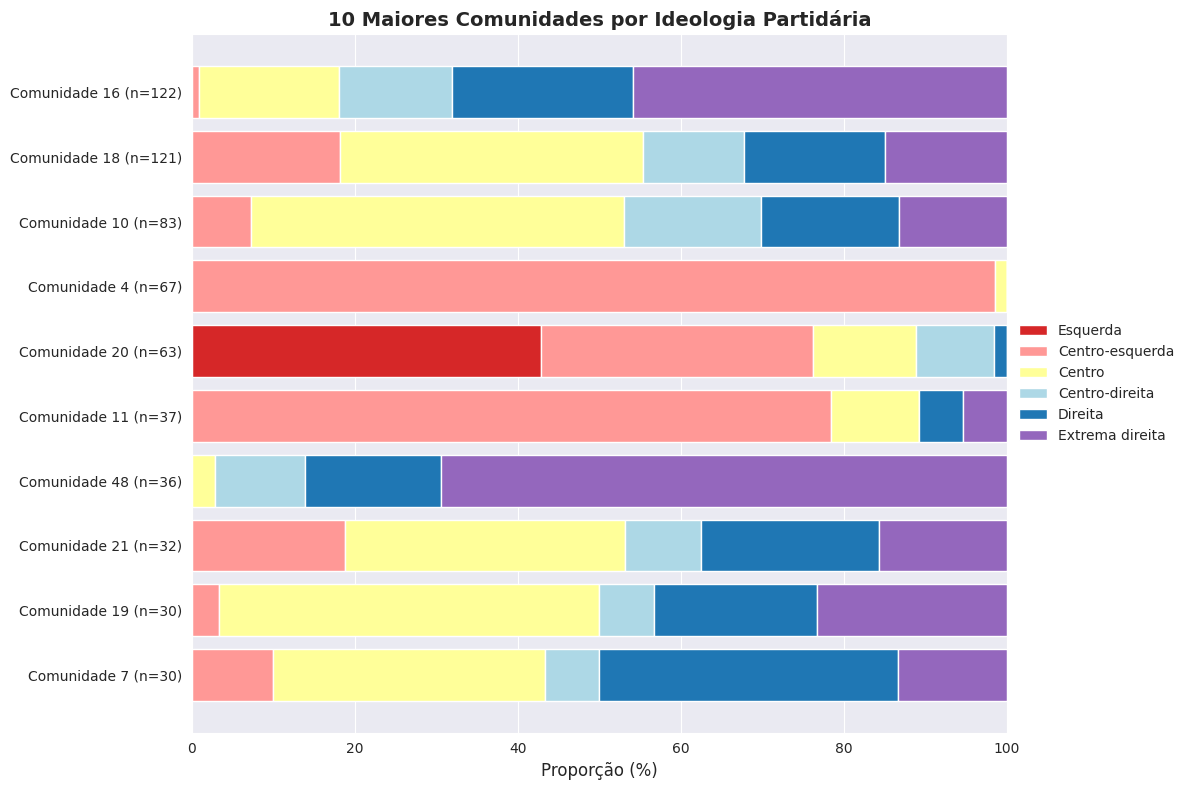

In [800]:
top10_leiden = leiden_summary.head(10).copy()


ideology_colors = {
    'left': '#d62728',          # red
    'centre-left': '#ff9896',   # light red
    'centre': '#ffff99',        # light yellow
    'centre-right': '#add8e6',  # light blue
    'right': '#1f77b4',         # blue
    'far-right': '#9467bd'      # purple
}

ideology_labels_pt = {
    'left': 'Esquerda',
    'centre-left': 'Centro-esquerda',
    'centre': 'Centro',
    'centre-right': 'Centro-direita',
    'right': 'Direita',
    'far-right': 'Extrema direita'
}

ideology_order = ['left', 'centre-left', 'centre', 'centre-right', 'right', 'far-right']

prop_df = top10_leiden[ideology_order].div(top10_leiden['total'], axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 8))

left = [0] * len(prop_df)
for ideology in ideology_order:
    if ideology in prop_df.columns:
        ax.barh(range(len(prop_df)), prop_df[ideology], left=left, 
                color=ideology_colors[ideology], label=ideology_labels_pt[ideology])
        left = [l + p for l, p in zip(left, prop_df[ideology])]

ax.set_yticks(range(len(prop_df)))
ax.set_yticklabels([f"Comunidade {idx} (n={top10_leiden.loc[idx, 'total']})" 
                     for idx in prop_df.index])
ax.set_xlabel('Proporção (%)', fontsize=12)
ax.set_title('10 Maiores Comunidades por Ideologia Partidária', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

ax.invert_yaxis()

plt.tight_layout()
plt.show()

Vemos que se pode estabelecer algumas distinções claras. Por exemplo, as comunidades 4, 11 e 20 têm uma predominância de parlamentares de esquerda e centro-esquerda, enquanto as comunidades 16 e 48 parecem aglomerar mais parlamentares de direita e centro-direita, e as demais abrangem majoritariamente o centro à direita.

Entretanto, como essa análise tratou o Senado como praticamente uma única comunidade em separado (comunidade 18), convém separar as Casas mais adiante.

#### 3.4.2.2 Cálculo de *betweenness*.

Vamos agora avaliar o *betweenness* do principal componente conexo, utilizando os pesos que definimos para as arestas, que correspondem ao score da proposição em questão.

In [801]:
# betwn_scores = main_g.betweenness(normalized=True, directed=False, weights=main_g.es['weight'])

# # Vamos salvar porque calcular betwenness demora um tempo

# with open(MAIN_G_BTWN_JSON, "w", encoding="utf8") as f:
#     json.dump(betwn_scores, f, indent="4")

In [802]:
with open(MAIN_G_BTWN_JSON, "r", encoding="utf8") as f:
    betwn_scores = json.load(f)

In [803]:
main_g.vs['betwn'] = betwn_scores
main_g.write_graphml(str(ACCESS_DIR / "bills_authors_communities.graphml"))

Agora vamos elencar autores e proposições por essa métrica de *betweenness*:

In [804]:
node_betwn_df = add_column_from_graph(main_g, node_df, "betwn")
node_betwn_df

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn
0,CP:2187087,PL 5029/2019,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none,4.000000e+01
1,CP:2190408,PL 2/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,4.000000e+01
2,CP:2190417,PL 10/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,4.000000e+01
3,CP:2190423,PL 15/2019,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,4.000206e+01
4,CP:2190450,PL 21/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,4.000000e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29229,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,-1.00,author,,PSD,MT,centre,none,centro-oeste,4.000029e+01
29230,SE:7352398,CPI DA PANDEMIA,,Orgao,-1.00,author,,not_applicable,,none,none,none,4.000014e+01
29231,SE:55226,COMISSÃO DIRETORA,,Orgao,-1.00,author,,not_applicable,,none,none,none,4.130522e-08
29232,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,-1.00,author,,not_applicable,,none,none,none,4.000029e+01


Vejamos as proposições mais centrais:

In [805]:
node_betwn_df[node_betwn_df['type'].eq('Proposicao')].sort_values('betwn', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn
21049,CP:2404706,PEC 62/2023,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,40.158735
24034,CP:2436619,PEC 23/2024,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,40.113742
22593,CP:2419252,PEC 6/2024,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,40.107318
23542,CP:2431025,PL 1563/2024,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,40.081586
4791,CP:2261160,PL 4383/2020,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,40.076760
24789,CP:2448752,PEC 29/2024,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,40.070181
21173,CP:2406638,PEC 64/2023,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,40.061607
14170,CP:2332037,PEC 18/2022,,Proposicao,0.25,bill,PEC,not_applicable,,none,committee-1,none,40.057306
20027,CP:2388127,PLP 194/2023,,Proposicao,0.00,bill,PLP,not_applicable,,none,filed,none,40.054846
14834,CP:2336964,PEC 27/2022,,Proposicao,0.00,bill,PEC,not_applicable,,none,filed,none,40.054722


Isso não é surpresa. Toda PEC precisa da assinatura de um terço dos membros da casa legislativa em questão. Vamos excluí-las:

In [806]:
node_betwn_df[
    node_betwn_df['type'].eq('Proposicao')
    & node_betwn_df['billtype'].ne("PEC")
].sort_values('betwn', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn
23542,CP:2431025,PL 1563/2024,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,40.081586
4791,CP:2261160,PL 4383/2020,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,40.076760
20027,CP:2388127,PLP 194/2023,,Proposicao,0.00,bill,PLP,not_applicable,,none,filed,none,40.054846
23544,CP:2431027,PL 1565/2024,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,40.044197
27040,CP:549767,PL 5015/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,40.031093
4823,CP:2261307,PLP 226/2020,,Proposicao,0.00,bill,PLP,not_applicable,,none,filed,none,40.025541
13824,CP:2326811,PL 1567/2022,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,40.024589
14041,CP:2330607,PL 1798/2022,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none,40.022629
647,CP:2230831,PL 6183/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none,40.019542
11900,CP:2313313,PL 4563/2021,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none,40.018893


Vemos aí pouca surpresa também. São projetos com muitos autores. Temos:

* PL 1563/2024 - Isenção de IR para doações às enchentes do RS
* PL 4383/2020 - Banda larga para educação
* PLP 194/2023 - Altera o número de deputados

Nos parece que haverá uma correlação entre *betweenness* e número de autores por proposição. Vejamos:

In [807]:
props_n_authors_df = (
    node_betwn_df[node_betwn_df['type'].eq("Proposicao")].join(
        edge_main_df.groupby('to').agg(n_authors=('from', 'count')), on="name"
    )[['name', 'n_authors', 'betwn', 'billtype']])
props_n_authors_df

,name,n_authors,betwn,billtype
0,CP:2187087,4.0,40.000000,PL
1,CP:2190408,1.0,40.000000,PL
2,CP:2190417,1.0,40.000000,PL
3,CP:2190423,8.0,40.002064,PL
4,CP:2190450,2.0,40.000000,PL
...,...,...,...,...
29098,SP:8753534,1.0,40.000000,PLP
29099,SP:8757436,1.0,40.000000,PL
29100,SP:8769092,1.0,40.000000,PL
29101,SP:8771203,1.0,40.000000,PL


array([[<Axes: title={'center': 'betwn'}>]], dtype=object)

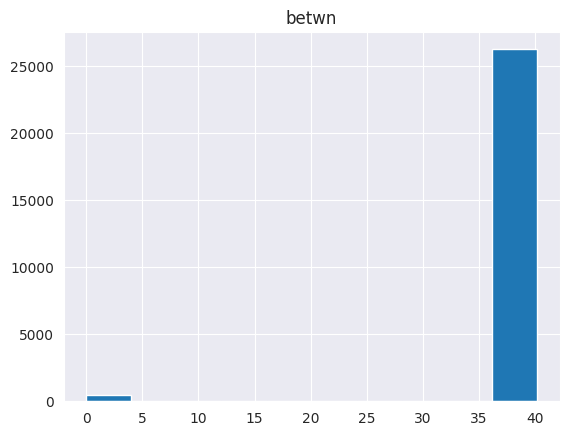

In [808]:
props_n_authors_df.hist('betwn')

Parece que os valores de betweenness se concentram a partir de 35. Vamos filtrar por esses valores e analisar a correlação.

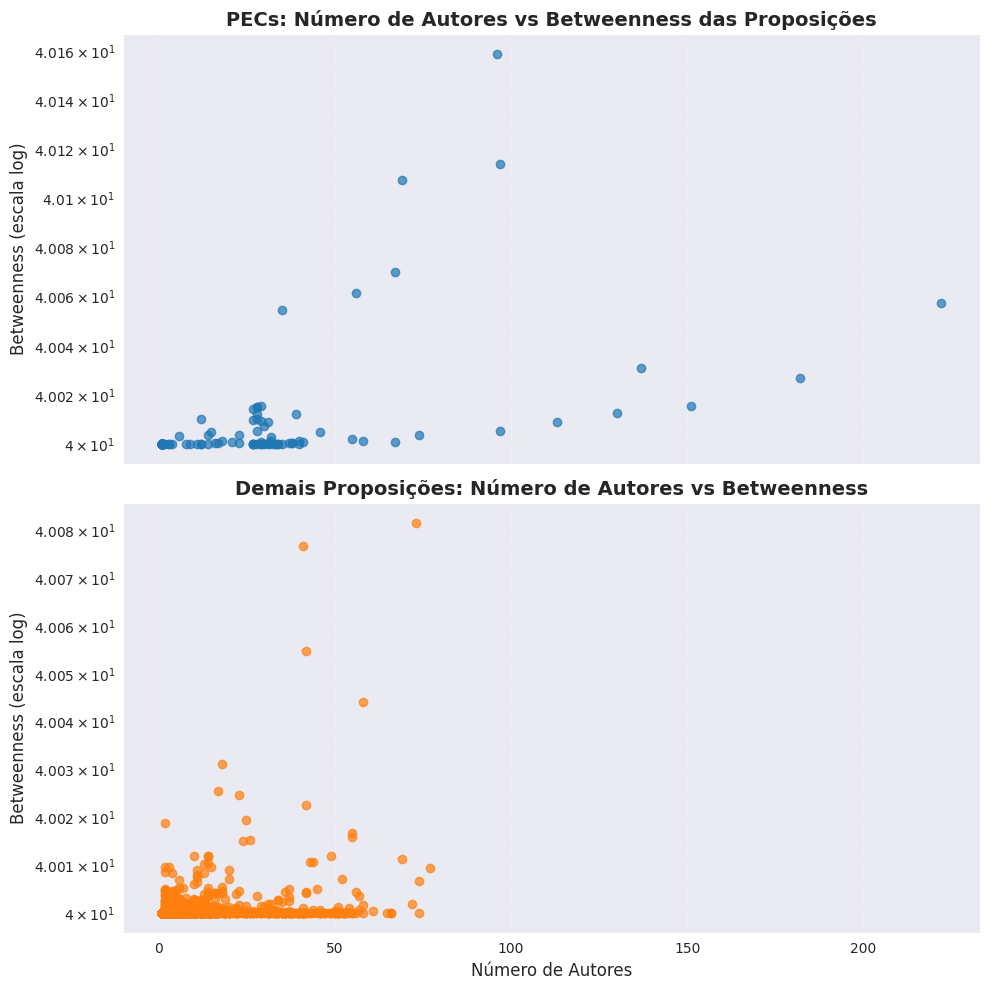

In [809]:
props_n_authors_df = (
    node_betwn_df[node_betwn_df['type'].eq("Proposicao")].join(
        edge_main_df.groupby('to').agg(n_authors=('from', 'count')), on="name"
    )[['name', 'n_authors', 'betwn', 'billtype']]
)

props_n_authors_df = props_n_authors_df[props_n_authors_df['betwn'].gt(35)]

# Split into PEC and non-PEC
is_pec = props_n_authors_df['billtype'].eq("PEC")
pec_df = props_n_authors_df[is_pec]
nonpec_df = props_n_authors_df[~is_pec]

# Create two vertically stacked subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Top: PECs
axes[0].scatter(
    pec_df['n_authors'].values,
    pec_df['betwn'].values,
    alpha=0.7,
)
axes[0].set_title('PECs: Número de Autores vs Betweenness das Proposições', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Betweenness (escala log)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.3)

# Bottom: non-PEC
axes[1].scatter(
    nonpec_df['n_authors'].values,
    nonpec_df['betwn'].values,
    alpha=0.7,
    color='C1',
)
axes[1].set_title('Demais Proposições: Número de Autores vs Betweenness', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Número de Autores', fontsize=12)
axes[1].set_ylabel('Betweenness (escala log)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.3)

axes[0].set_yscale("log")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()


Não parece haver correlação.

Vejamos como os parlamentares são afetados:

In [810]:
node_betwn_df[node_betwn_df['type'].eq('Deputado')].sort_values('betwn', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn
27375,CD:204544,ALEXANDRE FROTA DE ANDRADE,PSL/SP,Deputado,-1.0,author,,PSL,SP,far-right,none,sudeste,40.047207
27111,CD:139285,LÍDICE DA MATA E SOUZA,PSB/BA,Deputado,-1.0,author,,PSB,BA,centre-left,none,nordeste,40.031006
27246,CD:204472,JOSE ANTONIO DOS SANTOS MEDEIROS,PL/MT,Deputado,-1.0,author,,PL,MT,far-right,none,centro-oeste,40.029848
27759,CD:178857,JORGE JOSE SANTOS PEREIRA SOLLA,PT/BA,Deputado,-1.0,author,,PT,BA,centre-left,none,nordeste,40.027936
27066,CD:160575,ÉRIKA JUCÁ KOKAY,PT/DF,Deputado,-1.0,author,,PT,DF,centre-left,none,centro-oeste,40.026896
27559,CD:204534,TABATA CLAUDIA AMARAL DE PONTES,PSB/SP,Deputado,-1.0,author,,PSB,SP,centre-left,none,sudeste,40.026700
27499,CD:204536,KIM PATROCA KATAGUIRI,UNIÃO/SP,Deputado,-1.0,author,,UNIÃO,SP,centre-right,none,sudeste,40.025021
27724,CD:204572,ALBERTO BARROS CAVALCANTE NETO,PL/AM,Deputado,-1.0,author,,PL,AM,far-right,none,norte,40.024618
27296,CD:204391,JOSÉ NELTO LAGARES DAS MERCEZ,UNIÃO/GO,Deputado,-1.0,author,,UNIÃO,GO,centre-right,none,centro-oeste,40.022464
27049,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,-1.0,author,,PDT,RS,centre-left,none,sul,40.022287


In [811]:
node_betwn_df[node_betwn_df['type'].eq('Senador')].sort_values('betwn', ascending=False)[:10]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao,betwn
29162,SS:5352,ROGÉRIO CARVALHO SANTOS,PT/SE,Senador,-1.0,author,,PT,SE,centre-left,none,nordeste,40.078492
29169,SS:5322,ROMARIO DE SOUZA FARIA,PL/RJ,Senador,-1.0,author,,PL,RJ,far-right,none,sudeste,40.028884
29175,SS:5793,HIRAN MANUEL GONÇALVES DA SILVA,PP/RR,Senador,-1.0,author,,PP,RR,right,none,norte,40.013101
29123,SS:2331,ROSILDA DE FREITAS,MDB/ES,Senador,-1.0,author,,MDB,ES,centre,none,sudeste,40.011608
29202,SS:4639,JOSÉ ROBERTO OLIVEIRA FARO,PT/PA,Senador,-1.0,author,,PT,PA,centre-left,none,norte,40.010087
29180,SS:4642,EFRAIM DE ARAÚJO MORAIS FILHO,UNIÃO/PB,Senador,-1.0,author,,UNIÃO,PB,centre-right,none,nordeste,40.008090
29224,SS:5672,ALAN RICK MIRANDA,UNIÃO/AC,Senador,-1.0,author,,UNIÃO,AC,centre-right,none,norte,40.006411
29149,SS:825,PAULO RENATO PAIM,PT/RS,Senador,-1.0,author,,PT,RS,centre-left,none,sul,40.003973
29129,SS:5012,RANDOLPH FREDERICH RODRIGUES ALVES,PT/AP,Senador,-1.0,author,,PT,AP,centre-left,none,norte,40.003452
29143,SS:945,ALVARO FERNANDES DIAS,PODEMOS/PR,Senador,-1.0,author,,PODE,PR,centre-right,none,sul,40.003357


Talvez aqui convenha uma análise gráfica do porquê de esses parlamentares serem considerados mais centrais.

In [812]:
main_g.write_graphml(str(ACCESS_DIR / "bills_authors_communities.graphml"))

![Frota](outputs/3-4-2-2-frota.png)
![Carvalho](outputs/3-4-2-2-rogerio.png)

Vemos que os parlamentares mais bem colocados na Câmara e do Senado têm uma série de projetos de autoria própria e participação em alguns projetos de mais peso. Isso logicamente aumenta o *betweenness*, pois eles são caminho único para chegar em qualquer um de seus projetos "solo". Precisamos mitigar esse efeito.

In [813]:
node_df[node_df['label'].str.contains("FROTA")]

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao
27375,CD:204544,ALEXANDRE FROTA DE ANDRADE,PSL/SP,Deputado,-1.0,author,,PSL,SP,far-right,none,sudeste


Confirmamos numericamente o caso do dep. Alexandre Frota.

In [814]:
FROTA_TAG = "CD:204544"

In [815]:
edge_df[edge_df['from'].eq(FROTA_TAG)]

,from,to,weight
552,CD:204544,CP:2225359,0.250001
663,CD:204544,CP:2230594,0.250001
935,CD:204544,CP:2236368,0.250001
936,CD:204544,CP:2236369,0.250001
937,CD:204544,CP:2236370,0.250001
...,...,...,...
26786,CD:204544,CP:2338773,0.250001
26819,CD:204544,CP:2339632,0.250001
26837,CD:204544,CP:2339959,0.250001
26841,CD:204544,CP:2340300,0.250001


In [816]:
edge_df[edge_df['from'].eq(FROTA_TAG)].join(
    props_n_authors_df.set_index("name", drop=True)[['n_authors', 'betwn']],
    on="to"
).value_counts('n_authors')

n_authors
1.0     660
2.0       5
5.0       2
25.0      2
6.0       1
7.0       1
26.0      1
Name: count, dtype: int64

### 3.4.3. Refinamento da métrica de performance de proposições

Com base nos resultados acima, vamos buscar uma outra maneira de avaliar se há parlamentares mais centrais na participação em projetos de lei bem-sucedidos. Queremos mitigar o efeito tanto de parlamentares que protocolam muitos projetos quanto pelo fato de que PECs têm muitos autores por definição.

#### 3.4.3.1 Grafo de colaborações

Vamos construir um **grafo de colaborações**.

Seja $G^\prime = (V_A^\prime, V_P^\prime, E^\prime)$ o principal componente conexo do nosso grafo bipartido $G$.

Chamaremos de $G_C = (V_C, E_C)$ a projeção bipartida desse grafo, em que $V_C = V_A^\prime$ e $E_C$ liga quaisquer $u,v\in V_C$ tais que exista ao menos uma colaboração entre os dois autores.

A cada $(u,v)\in E_C$ será atribuído um peso $w(u,v)$ que reflete a soma das frações dos scores de $V_P^\prime$ para aqueles autores.

Em português simples: suponhamos que os deputados Ana e Carlos foram coautores em três projetos de lei - PL 1, PL 2 e PL 3, com os seguintes scores e número de autores:

| Projeto | Nº autores | Score | 
| --- | --- | --- |
| PL 1 | 5 | 0,25 |
| PL 2 | 2 | 0,5 |
| PL 3 | 10 | 1,0 |

Dividimos cada score pelo número de autores: O PL 1 concede $0.25\div 5 = 0.05$ a cada autor, o PL 2 $0.5 \div 2 = 0.25$ e o PL 3 $1 \div 10 = 0.1$.

Assim, a aresta ligando Ana e Carlos terá peso $0.05 + 0.25 + 0.1 = 0.4$.

**Algoritmicamente:**

Partimos do grafo $G^\prime(V_A^\prime,V_P^\prime, E^\prime)$ do principal componente conexo conforme definido acima.

Definimos $E_C$ como um novo conjunto de arestas, existindo uma aresta $(u,v)\in E_C$ para qualquer par $u, v \in V_A^\prime$ tal que tenham ao menos um vértice $v_p\in V_P^\prime$ adjacente em comum.

Definimos $V_C := V_A^\prime$ e daí definimos $G_C=(V_C, E_C)$.

Atribuímos inicialmente $e.weight = 0$ a toda aresta $e \in E_C$.

Então:

Para cada $e := (u, v) \in E_C$:

&nbsp;&nbsp;&nbsp;&nbsp;$V_P^{\prime\prime} := \{v_p \in V_P^\prime | v_p \text{ é adjacente a } u \text{ e } v\}$


&nbsp;&nbsp;&nbsp;&nbsp;Para cada $v_p$ em $V_P^{\prime\prime}$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$n_{v_p} :=$ o número de vértices adjacentes a $v_p$ em $V_A^{\prime}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$e.weight := e.weight + \frac{v_p.score}{n_{v_p}}$



Implementamos isso abaixo:

In [817]:
bill_nodes_df = node_main_df.join(edge_main_df.groupby('to').agg(
    n_authors=('from', 'count'),
    authors=('from', set)
),
    on="name",
    how="inner",
)
bill_nodes_df = bill_nodes_df[
    bill_nodes_df['n_authors'].gt(1)
]

bill_nodes_df[['score', 'n_authors', 'authors']].isna().any()
bill_nodes_df['score_share'] = bill_nodes_df['score'] / bill_nodes_df['n_authors']

In [818]:
authorship_edges = defaultdict(float)
authorship_nodes = set()

for index, row in bill_nodes_df.iterrows():
    score_share = row['score']
    for a1, a2 in itertools.pairwise(row['authors']):
        edge_key = tuple(sorted([a1, a2]))
        authorship_nodes.update(edge_key)
        authorship_edges[edge_key] += score_share
        
authorship_edges

defaultdict(float,
            {('CD:143632', 'CD:178879'): 1.0,
             ('CD:143632', 'CD:178975'): 1.0,
             ('CD:160541', 'CD:178975'): 1.0,
             ('CD:204528', 'CD:204532'): 6.75,
             ('CD:156190', 'CD:204532'): 5.5,
             ('CD:156190', 'CD:204461'): 7.25,
             ('CD:204461', 'CD:204519'): 5.0,
             ('CD:204365', 'CD:204519'): 2.75,
             ('CD:204365', 'CD:204516'): 2.5,
             ('CD:204516', 'CD:204523'): 5.5,
             ('CD:160518', 'CD:178927'): 2.25,
             ('CD:204508', 'CD:205535'): 0.25,
             ('CD:178989', 'CO:100292'): 3.0,
             ('CD:204420', 'CD:204449'): 0.25,
             ('CD:204369', 'CD:204449'): 0.25,
             ('CD:204369', 'CD:204545'): 0.25,
             ('CD:204526', 'CD:204545'): 1.5,
             ('CD:204400', 'CD:204526'): 0.25,
             ('CD:204400', 'CD:204462'): 0.25,
             ('CD:178947', 'CD:204462'): 0.75,
             ('CD:178947', 'CD:204536'): 0.25,
   

In [819]:
collab_node_df = node_main_df[node_main_df['name'].isin(authorship_nodes)].drop(['score', 'bigtype', 'billtype', 'score_label', 'leiden_mod_id'], axis=1)
collab_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste
...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none


In [820]:
collab_edge_df = pd.DataFrame([
    {'from': src, 'to': tgt, 'weight': wt}
    for (src, tgt), wt in authorship_edges.items()
])

Agora temos em `collab_node_df` e `collab_edge_df` um grafo conexo em que os autores são conectados por arestas indicando sua colaboração em projetos de lei em comum, sendo ponderadas pela performance acumulada conforme definido acima.

Queremos que o grafo se mantenha conexo, então vamos adicionar um $\varepsilon$ aos pesos:

In [821]:
EPSILON = 1e-6
collab_edge_df['weight'] += EPSILON

In [822]:
collab_g = build_graph(collab_node_df, collab_edge_df)
ccs = collab_g.connected_components()
len(ccs)


1

In [823]:
collab_node_df.shape, collab_edge_df.shape

((971, 8), (7742, 3))

#### 3.4.3.2. Análise do grafo de colaborações


Vejamos os graus do grafo de colaborações.

In [824]:
degrees = collab_g.degree()
avg_degree = sum(degrees) / len(degrees)
print(f"Grau médio: {avg_degree:.2f}")

Grau médio: 15.95


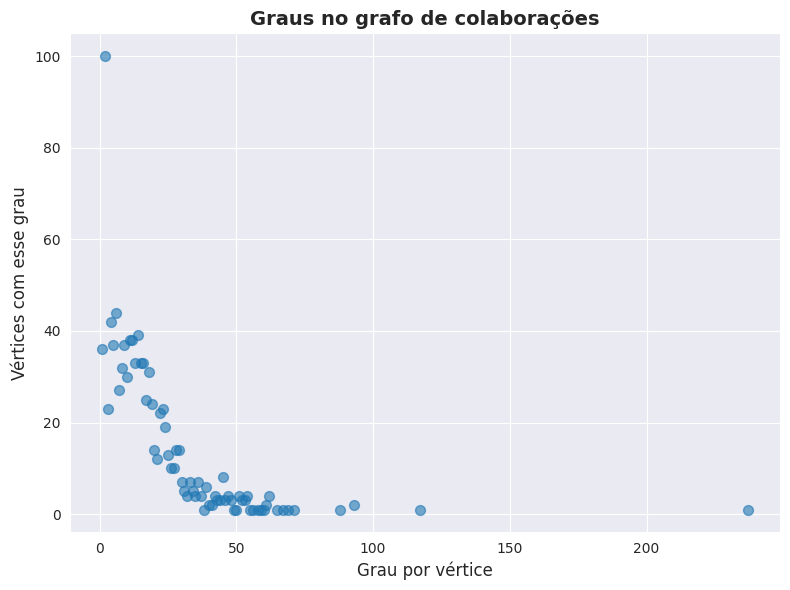

In [825]:
from collections import Counter
import matplotlib.pyplot as plt

# Get degree distribution
degrees = collab_g.degree()
degree_counts = Counter(degrees)

# Filter zero-degree nodes to avoid log-scale warnings
filtered_items = [(degree, count) for degree, count in degree_counts.items() if degree > 0 and count > 0]
if filtered_items:
    degrees_sorted, counts = zip(*sorted(filtered_items))
    degrees_sorted = list(degrees_sorted)
    counts = list(counts)
else:
    degrees_sorted = sorted(degree_counts.keys())
    counts = [degree_counts[d] for d in degrees_sorted]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(degrees_sorted, counts, alpha=0.6, s=50)
plt.xlabel('Grau por vértice', fontsize=12)
plt.ylabel('Vértices com esse grau', fontsize=12)
plt.title('Graus no grafo de colaborações', fontsize=14, fontweight='bold')
# plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Recalculamos o *betweenness* (esse não precisa gravar pois foi calculado bem rapidamente).

In [826]:
betwn_scores_frac = collab_g.betweenness(normalized=True, directed=False, weights=collab_g.es['weight'])

In [827]:
collab_g.vs['btwn'] = betwn_scores_frac

In [828]:
collab_node_df = add_column_from_graph(collab_g, collab_node_df, "btwn")
collab_node_df.head()

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste,0.000000
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul,0.000000
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul,0.000000
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul,0.007025
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste,0.000000


Vamos fazer um novo "ranking" de centralidade:

In [829]:
collab_node_df[collab_node_df['type'].eq("Deputado")].sort_values('btwn', ascending=False)[:10]

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn
26113,CD:204555,JOSÉ RICARDO WENDLING,PT/AM,Deputado,PT,AM,centre-left,norte,0.173337
26175,CD:204407,FERNANDA MELCHIONNA E SILVA,PSOL/RS,Deputado,PSOL,RS,left,sul,0.106854
25967,CD:220543,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,Deputado,REPUBLICANOS,TO,right,norte,0.083899
26293,CD:74848,JANDIRA FEGHALI,PCdoB/RJ,Deputado,PCdoB,RJ,left,sudeste,0.077809
26397,CD:74398,MARIA DO ROSÁRIO NUNES,PT/RS,Deputado,PT,RS,centre-left,sul,0.076772
25713,CD:178871,EVAIR VIEIRA DE MELO,PP/ES,Deputado,PP,ES,right,sudeste,0.070631
25946,CD:160598,FLÁVIA CARREIRO ALBUQUERQUE MORAIS,PDT/GO,Deputado,PDT,GO,centre-left,centro-oeste,0.061419
26416,CD:204464,TALIRIA PETRONE SOARES,PSOL/RJ,Deputado,PSOL,RJ,left,sudeste,0.059275
26009,CD:204536,KIM PATROCA KATAGUIRI,UNIÃO/SP,Deputado,UNIÃO,SP,centre-right,sudeste,0.053775
25615,CD:160575,ÉRIKA JUCÁ KOKAY,PT/DF,Deputado,PT,DF,centre-left,centro-oeste,0.052185


In [830]:
collab_node_df[collab_node_df['type'].eq("Senador")].sort_values('btwn', ascending=False)[:10]

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn
27608,SS:5352,ROGÉRIO CARVALHO SANTOS,PT/SE,Senador,PT,SE,centre-left,nordeste,0.168400
27659,SS:5953,FABIANO CONTARATO,PT/ES,Senador,PT,ES,centre-left,sudeste,0.047356
27597,SS:5718,ELIZIANE PEREIRA GAMA MELO,PSD/MA,Senador,PSD,MA,centre,nordeste,0.040862
27649,SS:5525,OMAR JOSÉ ABDEL AZIZ,PSD/AM,Senador,PSD,AM,centre,norte,0.039175
27569,SS:2331,ROSILDA DE FREITAS,MDB/ES,Senador,MDB,ES,centre,sudeste,0.033503
27648,SS:4639,JOSÉ ROBERTO OLIVEIRA FARO,PT/PA,Senador,PT,PA,centre-left,norte,0.031529
27582,SS:5376,MARA CRISTINA GABRILLI,PSD/SP,Senador,PSD,SP,centre,sudeste,0.029567
27610,SS:5627,JEAN PAUL TERRA PRATES,PT/RN,Senador,PT,RN,centre-left,nordeste,0.025762
27572,SS:345,FLÁVIO JOSÉ ARNS,PSB/PR,Senador,PSB,PR,centre-left,sul,0.024676
27617,SS:5535,TELMÁRIO MOTA DE OLIVEIRA,PROS/RR,Senador,PROS,RR,centre,norte,0.024565


Vamos levantar dados sobre os cinco primeiros parlamentares de cada lista

In [831]:
house_top5_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod
26113,CD:204555,JOSÉ RICARDO WENDLING,PT/AM,Deputado,PT,AM,centre-left,norte,0.173337,2
26175,CD:204407,FERNANDA MELCHIONNA E SILVA,PSOL/RS,Deputado,PSOL,RS,left,sul,0.106854,5
25967,CD:220543,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,Deputado,REPUBLICANOS,TO,right,norte,0.083899,1
26293,CD:74848,JANDIRA FEGHALI,PCdoB/RJ,Deputado,PCdoB,RJ,left,sudeste,0.077809,8
26397,CD:74398,MARIA DO ROSÁRIO NUNES,PT/RS,Deputado,PT,RS,centre-left,sul,0.076772,8


Agora vamos procurar comunidades dentro do grafo. Vamos começar pelo grafo inteiro. Como os pesos das arestas têm um valor significativo em termos da qualidade de colaborações, vamos considerá-los nas comunidades também.

In [832]:
collab_g.vs['leiden_mod'] = collab_g.community_leiden("modularity", weights="weight").membership

Mas quem são essas comunidades? Vamos analisar.

In [833]:
collab_node_df = add_column_from_graph(collab_g, collab_node_df, "leiden_mod")
collab_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod
25596,CD:66828,FAUSTO RUY PINATO,PP/SP,Deputado,PP,SP,right,sudeste,0.000000,0
25597,CD:73463,OSMAR JOSÉ SERRAGLIO,PP/PR,Deputado,PP,PR,right,sul,0.000000,0
25598,CD:73472,GERVÁSIO JOSÉ DA SILVA,PSDB/SC,Deputado,PSDB,SC,centre,sul,0.000000,4
25599,CD:73486,DARCI POMPEO DE MATTOS,PDT/RS,Deputado,PDT,RS,centre-left,sul,0.007025,1
25600,CD:73545,EUSTÁQUIO LUCIANO ZICA,PT/SP,Deputado,PT,SP,centre-left,sudeste,0.000000,9
...,...,...,...,...,...,...,...,...,...,...
27675,SS:6295,CARLOS HENRIQUE BAQUETA FÁVARO,PSD/MT,Senador,PSD,MT,centre,centro-oeste,0.000035,3
27676,SE:7352398,CPI DA PANDEMIA,,Orgao,not_applicable,,none,none,0.000000,3
27677,SE:55226,COMISSÃO DIRETORA,,Orgao,not_applicable,,none,none,0.000000,3
27678,SE:3947422,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,,Orgao,not_applicable,,none,none,0.000000,3


In [834]:
collab_node_df.groupby('leiden_mod')['type'].value_counts().unstack()

type,Deputado,Orgao,Senador
leiden_mod,,,
0,368.0,4.0,3.0
1,266.0,NaN,NaN
2,2.0,NaN,NaN
3,5.0,5.0,123.0
4,74.0,NaN,NaN
5,7.0,NaN,NaN
6,34.0,NaN,1.0
7,51.0,NaN,NaN
8,16.0,NaN,NaN


As comunidades 0 e 6 agregam órgãos além de parlamentares. Vejamos quais são:

In [835]:
collab_node_df[collab_node_df['type'].eq("Orgao")][['label', 'leiden_mod']]

,label,leiden_mod
26431,MESA DIRETORA DA CÂMARA DOS DEPUTADOS,0
26432,CÂMARA DOS DEPUTADOS,0
26433,SENADO FEDERAL,3
26434,COMISSÃO DE TURISMO,0
26435,COMISSÃO ESPECIAL DESTINADA A ACOMPANHAR AS AÇ...,0
27676,CPI DA PANDEMIA,3
27677,COMISSÃO DIRETORA,3
27678,COMISSÃO DE DIREITOS HUMANOS E LEGISLAÇÃO PART...,3
27679,COMISSÃO DE MEIO AMBIENTE,3


Vejamos como fica a distribuição de partidos:

In [836]:
collab_node_df.groupby('leiden_mod')['ideol_partido'].value_counts().unstack()

ideol_partido,centre,centre-left,centre-right,far-right,left,none,right
leiden_mod,,,,,,,
0,114.0,67.0,51.0,46.0,2.0,4.0,91.0
1,55.0,8.0,54.0,98.0,NaN,NaN,51.0
2,NaN,1.0,NaN,NaN,NaN,NaN,1.0
3,46.0,23.0,19.0,18.0,NaN,6.0,21.0
4,13.0,32.0,4.0,2.0,21.0,NaN,2.0
5,NaN,6.0,NaN,NaN,1.0,NaN,NaN
6,3.0,28.0,NaN,1.0,3.0,NaN,NaN
7,6.0,35.0,4.0,NaN,1.0,NaN,5.0
8,3.0,2.0,3.0,3.0,NaN,NaN,5.0


In [837]:
leiden_summary = collab_node_df[collab_node_df['ideol_partido'].ne('none')].groupby('leiden_mod')['ideol_partido'].value_counts().unstack().fillna(0).astype(int)
leiden_summary['total'] = leiden_summary.sum(axis=1)
leiden_summary = leiden_summary.sort_values('total', ascending=False)
leiden_summary


ideol_partido,centre,centre-left,centre-right,far-right,left,right,total
leiden_mod,,,,,,,
0,114,67,51,46,2,91,371
1,55,8,54,98,0,51,266
3,46,23,19,18,0,21,127
4,13,32,4,2,21,2,74
7,6,35,4,0,1,5,51
6,3,28,0,1,3,0,35
8,3,2,3,3,0,5,16
9,3,9,0,0,0,0,12
5,0,6,0,0,1,0,7


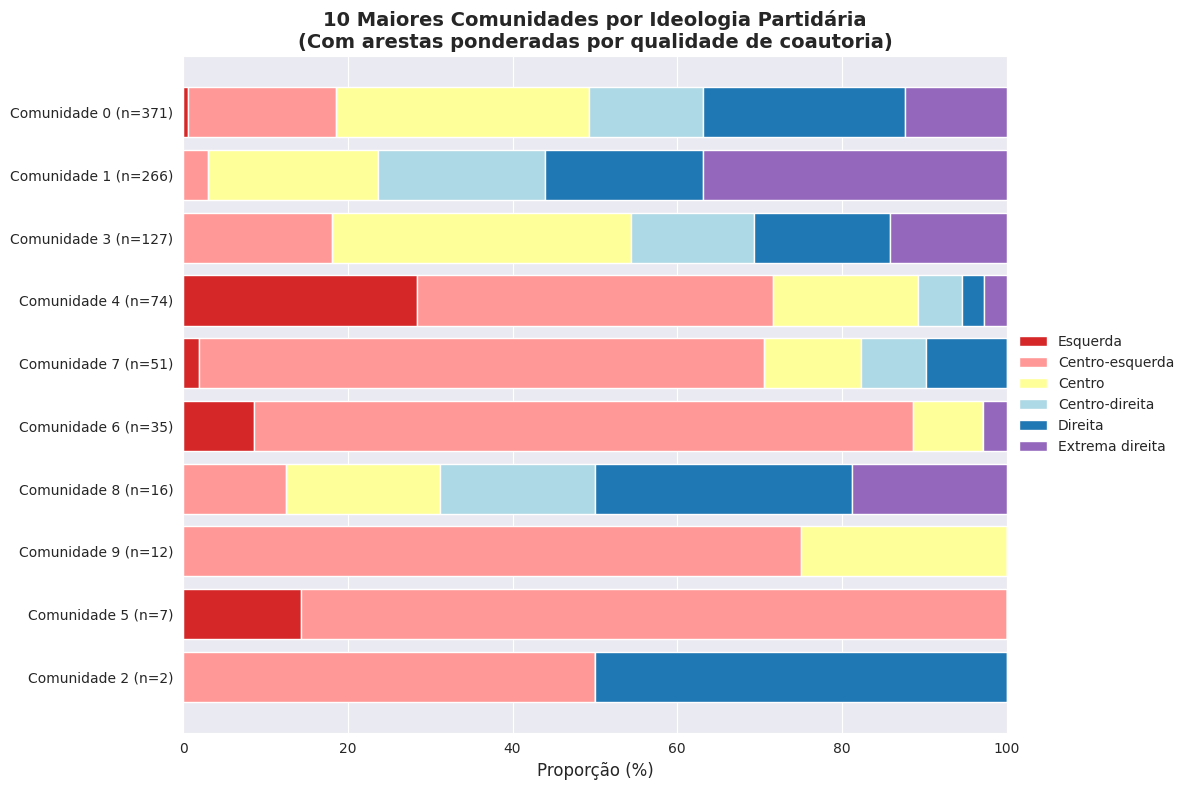

In [838]:
top10_leiden = leiden_summary.head(10).copy()


ideology_colors = {
    'left': '#d62728',          # red
    'centre-left': '#ff9896',   # light red
    'centre': '#ffff99',        # light yellow
    'centre-right': '#add8e6',  # light blue
    'right': '#1f77b4',         # blue
    'far-right': '#9467bd'      # purple
}

ideology_labels_pt = {
    'left': 'Esquerda',
    'centre-left': 'Centro-esquerda',
    'centre': 'Centro',
    'centre-right': 'Centro-direita',
    'right': 'Direita',
    'far-right': 'Extrema direita'
}

ideology_order = ['left', 'centre-left', 'centre', 'centre-right', 'right', 'far-right']

prop_df = top10_leiden[ideology_order].div(top10_leiden['total'], axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 8))

left = [0] * len(prop_df)
for ideology in ideology_order:
    if ideology in prop_df.columns:
        ax.barh(range(len(prop_df)), prop_df[ideology], left=left, 
                color=ideology_colors[ideology], label=ideology_labels_pt[ideology])
        left = [l + p for l, p in zip(left, prop_df[ideology])]

ax.set_yticks(range(len(prop_df)))
ax.set_yticklabels([f"Comunidade {idx} (n={top10_leiden.loc[idx, 'total']})" 
                     for idx in prop_df.index])
ax.set_xlabel('Proporção (%)', fontsize=12)
ax.set_title('10 Maiores Comunidades por Ideologia Partidária\n(Com arestas ponderadas por qualidade de coautoria)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

ax.invert_yaxis()

plt.tight_layout()
plt.show()

Ao que parece, quando levamos em conta a performance de projetos de lei, os parlamentares de esquerda e centro-esquerda ficam mais fragmentados nas comunidades, enquanto o restante do espectro político se aglomera em uma comunidade majoritária. Exceção feita à comunidade 3, que abrange a maior parte do Senado.

Vejamos como as comunidades se distribuem graficamente.

In [839]:
collab_g.write_graphml(str(ACCESS_DIR / "author_collab.graphml"))

Novamente comparamos a distribuição ideológica com as comunidades Leiden:

![Ideológica](outputs/3-4-3-2-ideol.png)

![Leiden](outputs/3-4-3-2-leiden.png)

Filtramos também os 10% de vértices com maior _betweenness_ e aplicamos ambas paletas para comparação:

![Ideológico (filtrado)](outputs/3-4-3-2-filter-ideol.png)

![Leiden (filtrado)](outputs/3-4-3-2-filter-leiden.png)

#### 3.4.3.3. Levantamento dos parlamentares mais centrais

Para encerrar esta seção, vamos examinar brevemente a produção legislativa dos parlamentares com maior *betweenness*.

Começamos pela Câmara.

In [840]:
house_top5_df = collab_node_df[collab_node_df['type'].eq("Deputado")].sort_values("btwn", ascending=False)[:5]
house_top5_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod
26113,CD:204555,JOSÉ RICARDO WENDLING,PT/AM,Deputado,PT,AM,centre-left,norte,0.173337,6
26175,CD:204407,FERNANDA MELCHIONNA E SILVA,PSOL/RS,Deputado,PSOL,RS,left,sul,0.106854,4
25967,CD:220543,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,Deputado,REPUBLICANOS,TO,right,norte,0.083899,0
26293,CD:74848,JANDIRA FEGHALI,PCdoB/RJ,Deputado,PCdoB,RJ,left,sudeste,0.077809,6
26397,CD:74398,MARIA DO ROSÁRIO NUNES,PT/RS,Deputado,PT,RS,centre-left,sul,0.076772,6


In [841]:
auth_tag = "CD:204503"

In [600]:
def get_main_bills_for_author(auth_tag):
    return (
        edges_df[edges_df["source"].eq(auth_tag)]
        .join(nodes_df.set_index("tag", drop=True)[["label"]], on="source")
        .join(
            nodes_df.set_index("tag", drop=True)[["label"]],
            on="target",
            lsuffix="_auth",
            rsuffix="_bill",
        )
        .join(
            node_df[node_df["bigtype"].eq("bill")].set_index("label", drop=True)[
                ["score"]
            ],
            on="label_bill",
        )
        .join(
            node_df[node_df["bigtype"].eq("author")].set_index("label", drop=True)[
                ["partido"]
            ],
            on="label_auth",
        )[["label_auth", "partido", "label_bill", "score"]]
    )

In [601]:
tags = house_top5_df['name']
house_dfs = [get_main_bills_for_author(tag) for tag in tags]

In [602]:
house_dfs[0]

,label_auth,partido,label_bill,score
797,JOSÉ RICARDO WENDLING,PT/AM,PL 6462/2019,0.00
1571,JOSÉ RICARDO WENDLING,PT/AM,PL 743/2020,0.25
1573,JOSÉ RICARDO WENDLING,PT/AM,PL 745/2020,0.25
1577,JOSÉ RICARDO WENDLING,PT/AM,PL 749/2020,0.25
1643,JOSÉ RICARDO WENDLING,PT/AM,PL 832/2020,0.00
...,...,...,...,...
27362,JOSÉ RICARDO WENDLING,PT/AM,PL 2590/2022,0.25
27899,JOSÉ RICARDO WENDLING,PT/AM,PL 1713/2019,0.25
28104,JOSÉ RICARDO WENDLING,PT/AM,PL 3426/2019,0.25
28168,JOSÉ RICARDO WENDLING,PT/AM,PEC 111/2019,0.25


In [603]:
house_dfs[0].value_counts('score')

score
0.25    146
0.00     30
1.00      7
0.50      2
0.75      1
Name: count, dtype: int64

In [604]:
house_dfs[1]


,label_auth,partido,label_bill,score
2091,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PL 698/2020,0.25
2228,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PL 1000/2020,0.25
2292,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PL 5250/2019,0.25
2802,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PL 6072/2019,0.25
3520,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PLP 85/2020,0.25
...,...,...,...,...
43875,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PL 4360/2024,0.25
43890,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PL 4519/2024,0.25
43954,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PLP 211/2024,0.25
44751,FERNANDA MELCHIONNA E SILVA,PSOL/RS,PL 4698/2024,0.25


In [605]:
house_dfs[1].value_counts('score')


score
0.25    136
0.00     34
1.00     10
0.50      4
Name: count, dtype: int64

In [606]:

house_dfs[2]


,label_auth,partido,label_bill,score
28746,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 210/2023,0.00
28814,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 278/2023,0.00
28854,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 319/2023,0.25
28855,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 320/2023,0.25
28954,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 433/2023,0.25
...,...,...,...,...
43116,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 3959/2024,0.00
43819,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 4653/2024,0.25
43820,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PL 4654/2024,0.25
44079,RICARDO AYRES DE CARVALHO,REPUBLICANOS/TO,PEC 42/2024,0.25


In [607]:

house_dfs[2].value_counts('score')


score
0.25    59
0.00    16
0.50     1
Name: count, dtype: int64

In [608]:

house_dfs[3]


,label_auth,partido,label_bill,score
2152,JANDIRA FEGHALI,PCdoB/RJ,PL 690/2020,0.25
2189,JANDIRA FEGHALI,PCdoB/RJ,PL 5626/2019,0.25
2241,JANDIRA FEGHALI,PCdoB/RJ,PL 5250/2019,0.25
2441,JANDIRA FEGHALI,PCdoB/RJ,PL 6183/2019,0.25
2750,JANDIRA FEGHALI,PCdoB/RJ,PL 153/2020,0.25
...,...,...,...,...
39901,JANDIRA FEGHALI,PCdoB/RJ,PL 2006/2024,0.00
41556,JANDIRA FEGHALI,PCdoB/RJ,PEC 27/2024,0.25
42916,JANDIRA FEGHALI,PCdoB/RJ,PL 2947/2024,0.25
42933,JANDIRA FEGHALI,PCdoB/RJ,PLP 136/2024,0.50


In [609]:
house_dfs[3].value_counts('score')


score
0.25    70
0.00    17
1.00     8
0.50     3
0.75     1
Name: count, dtype: int64

In [610]:

house_dfs[4]


,label_auth,partido,label_bill,score
1507,MARIA DO ROSÁRIO NUNES,PT/RS,PL 680/2020,0.25
2186,MARIA DO ROSÁRIO NUNES,PT/RS,PL 5250/2019,0.25
2268,MARIA DO ROSÁRIO NUNES,PT/RS,PL 813/2020,0.25
2510,MARIA DO ROSÁRIO NUNES,PT/RS,PL 4968/2019,1.00
2587,MARIA DO ROSÁRIO NUNES,PT/RS,PL 5756/2019,0.25
...,...,...,...,...
41527,MARIA DO ROSÁRIO NUNES,PT/RS,PEC 27/2024,0.25
42456,MARIA DO ROSÁRIO NUNES,PT/RS,PL 3675/2024,0.25
42894,MARIA DO ROSÁRIO NUNES,PT/RS,PL 2947/2024,0.25
43004,MARIA DO ROSÁRIO NUNES,PT/RS,PEC 34/2024,0.25


In [611]:

house_dfs[4].value_counts('score')

score
0.25    174
0.00     24
1.00     17
0.50      5
0.75      3
Name: count, dtype: int64

Confirmamos o que já suspeitávamos. Cada um deles tem uma boa participação em projetos que avançaram em ambas as casas do Legislativo, alguns tendo chegado à aprovação nas duas casas.

Vejamos agora o Senado.

In [612]:
senate_top5_df = collab_node_df[collab_node_df['type'].eq("Senador")].sort_values("btwn", ascending=False)[:5]
senate_top5_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod
27608,SS:5352,ROGÉRIO CARVALHO SANTOS,PT/SE,Senador,PT,SE,centre-left,nordeste,0.168400,4
27659,SS:5953,FABIANO CONTARATO,PT/ES,Senador,PT,ES,centre-left,sudeste,0.047356,4
27597,SS:5718,ELIZIANE PEREIRA GAMA MELO,PSD/MA,Senador,PSD,MA,centre,nordeste,0.040862,4
27649,SS:5525,OMAR JOSÉ ABDEL AZIZ,PSD/AM,Senador,PSD,AM,centre,norte,0.039175,4
27569,SS:2331,ROSILDA DE FREITAS,MDB/ES,Senador,MDB,ES,centre,sudeste,0.033503,4


In [613]:
tags = senate_top5_df['name']
senate_dfs = [get_main_bills_for_author(tag) for tag in tags]

In [614]:
senate_dfs[0]


,label_auth,partido,label_bill,score
45015,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 1749/2019,0.75
45025,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 1914/2019,0.25
45507,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 774/2020,0.00
45514,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 800/2020,0.25
45523,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 833/2020,0.00
...,...,...,...,...
49322,ROGÉRIO CARVALHO SANTOS,PT/SE,PEC 32/2022 (FASE 2),0.00
49451,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 5523/2023,0.75
49745,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 2935/2024,0.75
49757,ROGÉRIO CARVALHO SANTOS,PT/SE,PL 3060/2024,0.75


In [615]:

senate_dfs[0].value_counts('score')


score
0.00    45
0.25    34
0.75    14
0.50     3
Name: count, dtype: int64

In [616]:
senate_dfs[1]


,label_auth,partido,label_bill,score
44882,FABIANO CONTARATO,PT/ES,PL 1211/2019,0.75
44956,FABIANO CONTARATO,PT/ES,PEC 2/2019,0.25
44983,FABIANO CONTARATO,PT/ES,PEC 13/2019,0.75
45018,FABIANO CONTARATO,PT/ES,PL 1822/2019,0.75
45177,FABIANO CONTARATO,PT/ES,PL 4256/2019,0.75
...,...,...,...,...
48862,FABIANO CONTARATO,PT/ES,PL 2840/2022,0.75
49286,FABIANO CONTARATO,PT/ES,PEC 22/2022,0.00
49303,FABIANO CONTARATO,PT/ES,PEC 32/2022,0.75
49306,FABIANO CONTARATO,PT/ES,PEC 32/2022 (FASE 2),0.00


In [617]:

senate_dfs[1].value_counts('score')


score
0.25    25
0.75    22
0.00    12
1.00     3
0.50     1
Name: count, dtype: int64

In [618]:

senate_dfs[2]


,label_auth,partido,label_bill,score
45492,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PL 509/2020,0.75
45546,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PL 951/2020,0.00
45558,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PL 1017/2020,0.25
45559,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PLP 51/2020,0.00
45685,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PL 1644/2020,0.25
...,...,...,...,...
49214,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PEC 22/2022,0.00
49264,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PEC 32/2022,0.75
49267,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PEC 32/2022 (FASE 2),0.00
49472,ELIZIANE PEREIRA GAMA MELO,PSD/MA,PL 6103/2023,0.75


In [619]:
senate_dfs[2].value_counts('score')


score
0.25    18
0.00    15
0.75    12
0.50     1
Name: count, dtype: int64

In [620]:
senate_dfs[3]


,label_auth,partido,label_bill,score
44933,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PEC 9/2019,0.25
45569,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PL 1059/2020,0.00
45583,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PL 1128/2020,0.25
45836,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PEC 209/2019,0.25
45929,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PEC 13/2019,0.75
...,...,...,...,...
48718,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PEC 1/2022,0.75
49137,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PEC 33/2022,0.25
49158,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PEC 22/2022,0.00
49184,OMAR JOSÉ ABDEL AZIZ,PSD/AM,PEC 32/2022,0.75


In [621]:
senate_dfs[3].value_counts('score')


score
0.25    11
0.75     8
0.00     7
1.00     1
Name: count, dtype: int64

In [622]:
senate_dfs[4]


,label_auth,partido,label_bill,score
44909,ROSILDA DE FREITAS,MDB/ES,PEC 9/2019,0.25
44910,ROSILDA DE FREITAS,MDB/ES,PEC 12/2019,0.25
44978,ROSILDA DE FREITAS,MDB/ES,PEC 2/2019,0.25
44980,ROSILDA DE FREITAS,MDB/ES,PL 1350/2019,0.25
44985,ROSILDA DE FREITAS,MDB/ES,PLP 57/2019,0.25
...,...,...,...,...
49100,ROSILDA DE FREITAS,MDB/ES,PEC 46/2022,0.25
49144,ROSILDA DE FREITAS,MDB/ES,PEC 32/2022,0.75
49147,ROSILDA DE FREITAS,MDB/ES,PEC 32/2022 (FASE 2),0.00
49193,ROSILDA DE FREITAS,MDB/ES,PEC 33/2022,0.25


In [623]:
senate_dfs[4].value_counts('score')


score
0.25    93
0.00    86
0.75    17
0.50     1
Name: count, dtype: int64

No Senado observamos uma incidência menor de proposições com score 1.0, mas a dsitribuição de scores continua favorável a números maiores.

Gravamos o grafo de colaborações para uso na próxima seção.

In [624]:
collab_node_df.to_pickle(ACCESS_DIR / "collab_node_df.pkl")
collab_edge_df.to_pickle(ACCESS_DIR / "collab_edge_df.pkl")

In [625]:
node_old_df = pd.read_pickle("../collab_node_df_old.pkl")
edge_old_df = pd.read_pickle("../collab_edge_df_old.pkl")

In [626]:
collab_node_df.describe()

,btwn,leiden_mod
count,971.000000,971.000000
mean,0.005252,2.848610
std,0.012511,2.255519
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000974,3.000000
75%,0.005692,4.000000
max,0.173337,10.000000


In [627]:
node_old_df.describe()

,btwn,leiden_mod
count,971.000000,971.000000
mean,0.005486,3.188465
std,0.013426,2.340700
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001064,4.000000
75%,0.005536,5.000000
max,0.171281,10.000000


In [628]:
collab_edge_df.describe()

,weight
count,7742.000000
mean,0.834508
std,2.111337
min,0.000001
25%,0.250001
50%,0.250001
75%,0.750001
max,34.000001


In [629]:
edge_old_df.describe()

,weight
count,7771.000000
mean,0.831393
std,2.074781
min,0.000001
25%,0.250001
50%,0.250001
75%,0.750001
max,38.500001


In [639]:
old_tuples = {"-".join(sorted((u,v))) for u, v in edge_old_df[['from', 'to']].values}

In [640]:
new_tuples = {"-".join(sorted((u,v))) for u, v in collab_edge_df[['from', 'to']].values}

In [644]:
new_tuples - old_tuples

{'CD:178963-CD:220558',
 'SS:5008-SS:5982',
 'CD:160592-CD:74052',
 'CD:204457-CD:221329',
 'SS:285-SS:4994',
 'CD:204366-CD:204394',
 'CD:160665-CD:74478',
 'CD:204512-CD:204569',
 'CD:204369-CD:220008',
 'CD:136811-CD:220557',
 'CD:204467-CD:209189',
 'CD:160553-CD:204501',
 'CD:160598-CD:220563',
 'CD:204492-CD:220688',
 'CD:160559-CD:220693',
 'CD:220583-CD:220705',
 'CD:220652-CD:220655',
 'CD:220555-CD:220586',
 'CD:204379-CD:220599',
 'CD:204572-CD:74398',
 'CD:178939-CD:204572',
 'CD:204422-CD:74041',
 'CD:160511-CD:204525',
 'CD:204518-CD:204524',
 'CD:204464-CD:204467',
 'CD:204530-CD:74554',
 'CD:178843-CD:204396',
 'CD:204457-CD:92102',
 'CD:204394-CD:204429',
 'CD:160538-CD:73701',
 'CD:161440-CD:220552',
 'SS:5502-SS:5525',
 'CD:160600-CD:220576',
 'CD:108338-CD:160587',
 'CD:188097-CD:191923',
 'CD:178997-CD:204441',
 'CD:220534-CD:74467',
 'CD:157130-CD:204510',
 'SS:5988-SS:6342',
 'SS:1023-SS:5783',
 'CD:141488-CD:204538',
 'CD:178871-CD:73441',
 'CD:160531-CD:204460'